In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Human_activity_recognition/

/content/drive/MyDrive/Human_activity_recognition


# Quick overview of the dataset :



* Accelerometer and Gyroscope readings are taken from 30 volunteers(referred as subjects) while performing the following 6 Activities.

    1. Walking     
    2. WalkingUpstairs 
    3. WalkingDownstairs 
    4. Standing 
    5. Sitting 
    6. Lying.


* Readings are divided into a window of 2.56 seconds with 50% overlapping. 

* Accelerometer readings are divided into gravity acceleration and body acceleration readings,
  which has x,y and z components each.

* Gyroscope readings are the measure of angular velocities which has x,y and z components.

* Jerk signals are calculated for BodyAcceleration readings.

* Fourier Transforms are made on the above time readings to obtain frequency readings.

* Now, on all the base signal readings., mean, max, mad, sma, arcoefficient, engerybands,entropy etc., are calculated for each window.

* We get a feature vector of 561 features and these features are given in the dataset.

* Each window of readings is a datapoint of 561 features.

## Problem Framework

* 30 subjects(volunteers) data is randomly split to 70%(21) test and 30%(7) train data.
* Each datapoint corresponds one of the 6 Activities.


## Problem Statement

 + Given a new datapoint we have to predict the Activity

In [ ]:
import numpy as np
import pandas as pd

# get the features from the file features.txt
features = list()
with open('UCI_HAR_Dataset/features.txt') as f:
    features = [line.split()[1] for line in f.readlines()]
print('No of Features: {}'.format(len(features)))


No of Features: 561


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

## Obtain the  train data 

In [ ]:
# get the data from txt files to pandas dataffame

X_train = pd.read_csv('UCI_HAR_Dataset/train/X_train.txt', delim_whitespace=True)
X_train.columns = features

# add subject column to the dataframe
X_train['subject'] = pd.read_csv('UCI_HAR_Dataset/train/subject_train.txt', header=None, squeeze=True)

X_train["Activity"] = pd.read_csv("UCI_HAR_Dataset/train/y_train.txt", header = None, squeeze = True)
activity = pd.read_csv("UCI_HAR_Dataset/train/y_train.txt", header = None, squeeze = True)

#mapping activity to activity name
label_name = activity.map({1: "WALKING", 2:"WALKING_UPSTAIRS", 3:"WALKING_DOWNSTAIRS", 4:"SITTING", 5:"STANDING", 6:"LYING"})

X_train["ActivityName"] = label_name
train = X_train
train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,ActivityName
0,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,5,STANDING
1,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,5,STANDING
2,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,5,STANDING
3,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,5,STANDING
4,0.277199,-0.010098,-0.105137,-0.997335,-0.990487,-0.995420,-0.997627,-0.990218,-0.995549,-0.942469,...,0.082632,-0.143439,0.275041,-0.368224,-0.849632,0.184823,-0.042126,1,5,STANDING


In [ ]:
train.shape

(7351, 564)

## Obtain the  test data 

In [ ]:
X_test = pd.read_csv('UCI_HAR_Dataset/test/X_test.txt', delim_whitespace=True)
X_test.columns = features

# add subject column to the dataframe
X_test['subject'] = pd.read_csv('UCI_HAR_Dataset/test/subject_test.txt', header=None, squeeze=True)

X_test["Activity"] = pd.read_csv("UCI_HAR_Dataset/test/y_test.txt", header = None, squeeze = True)
activity = pd.read_csv("UCI_HAR_Dataset/test/y_test.txt", header = None, squeeze = True)

#mapping activity to activity name
label_name = activity.map({1: "WALKING", 2:"WALKING_UPSTAIRS", 3:"WALKING_DOWNSTAIRS", 4:"SITTING", 5:"STANDING", 6:"LYING"})

X_test["ActivityName"] = label_name
test = X_test
test.head()


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,ActivityName
0,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,...,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898,2,5,STANDING
1,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,...,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346,2,5,STANDING
2,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,-0.968897,-0.938610,...,-0.017067,0.154438,0.340134,0.296407,-0.698954,0.284114,-0.077108,2,5,STANDING
3,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,-0.977346,-0.938610,...,-0.002223,-0.040046,0.736715,-0.118545,-0.692245,0.290722,-0.073857,2,5,STANDING
4,0.279220,-0.018620,-0.113902,-0.994455,-0.970417,-0.965316,-0.994585,-0.969481,-0.965897,-0.937856,...,-0.095681,0.048849,0.760684,-0.072216,-0.689816,0.294896,-0.068471,2,5,STANDING


In [ ]:
test.shape

(2946, 564)

# Data Cleaning

## 1. Check for Duplicates

In [ ]:
print('No of duplicates in train: {}'.format(sum(train.duplicated())))
print('No of duplicates in test : {}'.format(sum(test.duplicated())))

No of duplicates in train: 0
No of duplicates in test : 0


## 2. Checking for NaN/null values

In [ ]:
print('We have {} NaN/Null values in train'.format(train.isnull().values.sum()))
print('We have {} NaN/Null values in test'.format(test.isnull().values.sum()))

We have 0 NaN/Null values in train
We have 0 NaN/Null values in test


## 3. Check for data imbalance

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Dejavu Sans'

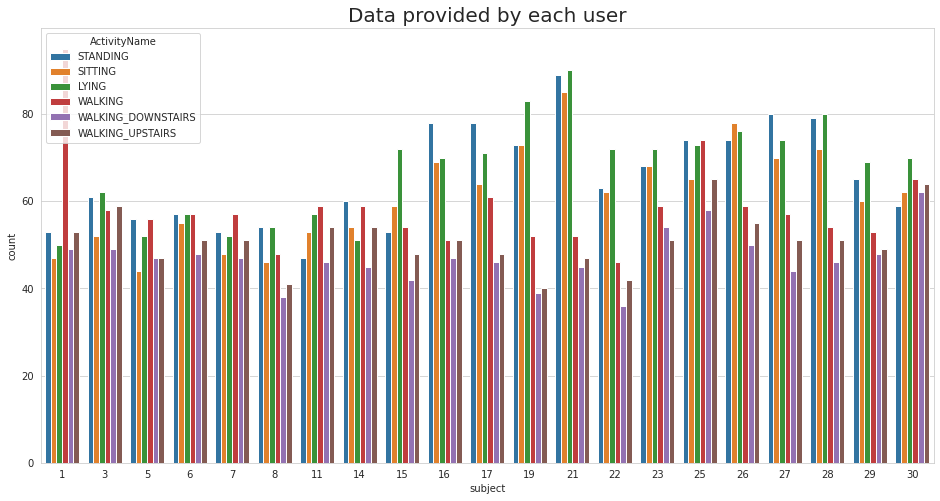

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Data provided by each user', fontsize=20)
sns.countplot(x='subject',hue='ActivityName', data = train)
plt.show()


> We have got almost same number of reading from all the subjects

C:\Users\User\anaconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


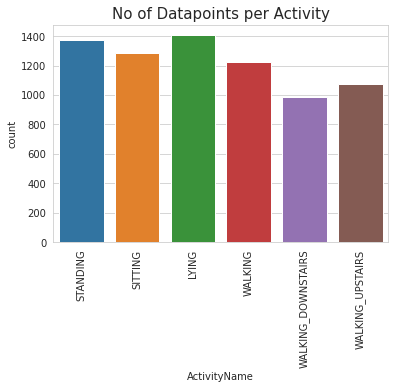

In [ ]:
plt.title('No of Datapoints per Activity', fontsize=15)
sns.countplot(train.ActivityName)
plt.xticks(rotation=90)
plt.show()

### Observation
> Our data is well balanced (almost)

## 4. Changing feature names 

In [ ]:
columns = train.columns

# Removing '()' from column names
columns = columns.str.replace('[()]','')
columns = columns.str.replace('[-]', '')
columns = columns.str.replace('[,]','')

train.columns = columns
test.columns = columns

test.columns

Index(['tBodyAccmeanX', 'tBodyAccmeanY', 'tBodyAccmeanZ', 'tBodyAccstdX',
       'tBodyAccstdY', 'tBodyAccstdZ', 'tBodyAccmadX', 'tBodyAccmadY',
       'tBodyAccmadZ', 'tBodyAccmaxX',
       ...
       'angletBodyAccMeangravity', 'angletBodyAccJerkMeangravityMean',
       'angletBodyGyroMeangravityMean', 'angletBodyGyroJerkMeangravityMean',
       'angleXgravityMean', 'angleYgravityMean', 'angleZgravityMean',
       'subject', 'Activity', 'ActivityName'],
      dtype='object', length=564)

## 5. Save this dataframe in a csv files

In [ ]:
train.to_csv('UCI_HAR_Dataset/csv_files/train.csv', index=False)
test.to_csv('UCI_HAR_Dataset/csv_files/test.csv', index=False)

# Exploratory Data Analysis

"___Without domain knowledge EDA has no meaning, without EDA a problem has no soul.___"

### 1. Featuring Engineering from Domain Knowledge 




+ __Static and Dynamic Activities__

    - In static activities (sit, stand, lie down) motion information will not be very useful.
	- In the dynamic activities (Walking, WalkingUpstairs,WalkingDownstairs) motion info will be significant.




### 2. Stationary and Moving activities are completely different

C:\Users\User\anaconda3\envs\tf-gpu\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\User\anaconda3\envs\tf-gpu\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\envs\tf-gpu\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\envs\tf-gpu\lib\site-pac

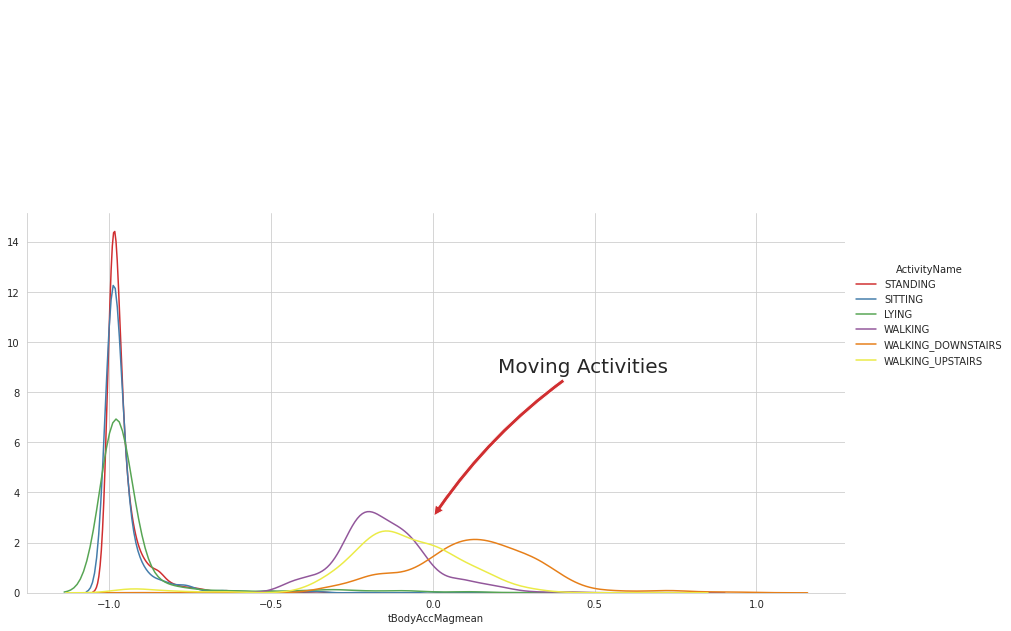

In [ ]:
sns.set_palette("Set1", desat=0.80)
facetgrid = sns.FacetGrid(train, hue='ActivityName', size=6,aspect=2)
facetgrid.map(sns.distplot,'tBodyAccMagmean', hist=False)\
    .add_legend()
plt.annotate("Stationary Activities", xy=(-0.956,17), xytext=(-0.9, 23), size=20,\
            va='center', ha='left',\
            arrowprops=dict(arrowstyle="simple",connectionstyle="arc3,rad=0.1"))

plt.annotate("Moving Activities", xy=(0,3), xytext=(0.2, 9), size=20,\
            va='center', ha='left',\
            arrowprops=dict(arrowstyle="simple",connectionstyle="arc3,rad=0.1"))
plt.show()

C:\Users\User\anaconda3\envs\tf-gpu\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\envs\tf-gpu\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\envs\tf-gpu\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function w

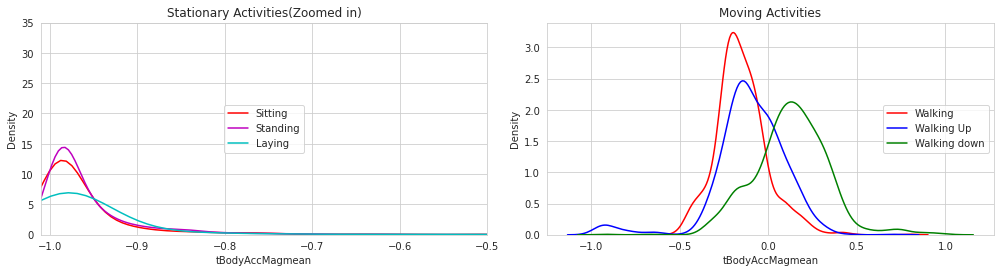

In [ ]:
# for plotting purposes taking datapoints of each activity to a different dataframe
df1 = train[train['Activity']==1]
df2 = train[train['Activity']==2]
df3 = train[train['Activity']==3]
df4 = train[train['Activity']==4]
df5 = train[train['Activity']==5]
df6 = train[train['Activity']==6]

plt.figure(figsize=(14,7))
plt.subplot(2,2,1)
plt.title('Stationary Activities(Zoomed in)')
sns.distplot(df4['tBodyAccMagmean'],color = 'r',hist = False, label = 'Sitting')
sns.distplot(df5['tBodyAccMagmean'],color = 'm',hist = False,label = 'Standing')
sns.distplot(df6['tBodyAccMagmean'],color = 'c',hist = False, label = 'Laying')
plt.axis([-1.01, -0.5, 0, 35])
plt.legend(loc='center')

plt.subplot(2,2,2)
plt.title('Moving Activities')
sns.distplot(df1['tBodyAccMagmean'],color = 'red',hist = False, label = 'Walking')
sns.distplot(df2['tBodyAccMagmean'],color = 'blue',hist = False,label = 'Walking Up')
sns.distplot(df3['tBodyAccMagmean'],color = 'green',hist = False, label = 'Walking down')
plt.legend(loc='center right')


plt.tight_layout()
plt.show()

### 3. Magnitude of an acceleration can saperate it well

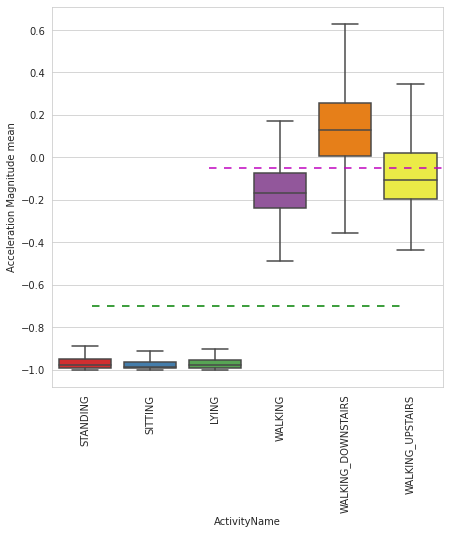

In [ ]:
plt.figure(figsize=(7,7))
sns.boxplot(x='ActivityName', y='tBodyAccMagmean',data=train, showfliers=False, saturation=1)
plt.ylabel('Acceleration Magnitude mean')
plt.axhline(y=-0.7, xmin=0.1, xmax=0.9,dashes=(5,5), c='g')
plt.axhline(y=-0.05, xmin=0.4, dashes=(5,5), c='m')
plt.xticks(rotation=90)
plt.show()

__ Observations__:
- If tAccMean is < -0.8 then the Activities are either Standing or Sitting or Laying.
- If tAccMean is > -0.6 then the Activities are either Walking or WalkingDownstairs or WalkingUpstairs.
- If tAccMean > 0.0 then the Activity is WalkingDownstairs.
- We can classify 75% the Acitivity labels with some errors.

### 4. Position of GravityAccelerationComponants also matters 

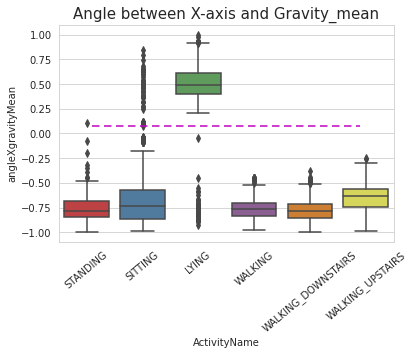

In [ ]:
sns.boxplot(x='ActivityName', y='angleXgravityMean', data=train)
plt.axhline(y=0.08, xmin=0.1, xmax=0.9,c='m',dashes=(5,3))
plt.title('Angle between X-axis and Gravity_mean', fontsize=15)
plt.xticks(rotation = 40)
plt.show()

__ Observations__:
* If angleX,gravityMean > 0 then Activity is Laying.
* We can classify all datapoints belonging to Laying activity with just a single if else statement.

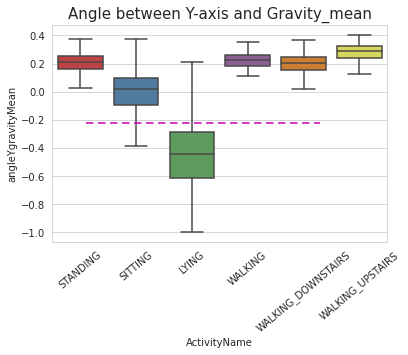

In [ ]:
sns.boxplot(x='ActivityName', y='angleYgravityMean', data = train, showfliers=False)
plt.title('Angle between Y-axis and Gravity_mean', fontsize=15)
plt.xticks(rotation = 40)
plt.axhline(y=-0.22, xmin=0.1, xmax=0.8, dashes=(5,3), c='m')
plt.show()

# Apply t-sne on the data 

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# performs t-sne with different perplexity values and their repective plots..

def perform_tsne(X_data, y_data, perplexities, n_iter=1000, img_name_prefix='t-sne'):
        
    for index,perplexity in enumerate(perplexities):
        # perform t-sne
        print('\nperforming tsne with perplexity {} and with {} iterations at max'.format(perplexity, n_iter))
        X_reduced = TSNE(verbose=2, perplexity=perplexity).fit_transform(X_data)
        print('Done..')
        
        # prepare the data for seaborn         
        print('Creating plot for this t-sne visualization..')
        df = pd.DataFrame({'x':X_reduced[:,0], 'y':X_reduced[:,1] ,'label':y_data})
        
        # draw the plot in appropriate place in the grid
        sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,\
                   palette="Set1",markers=['^','v','s','o', '1','2'])
        plt.title("perplexity : {} and max_iter : {}".format(perplexity, n_iter))
        img_name = img_name_prefix + '_perp_{}_iter_{}.png'.format(perplexity, n_iter)
        print('saving this plot as image in present working directory...')
        plt.savefig(img_name)
        plt.show()
        print('Done')



performing tsne with perplexity 2 and with 1000 iterations at max
[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 7351 samples in 0.005s...
[t-SNE] Computed neighbors for 7351 samples in 1.817s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7351
[t-SNE] Computed conditional probabilities for sample 2000 / 7351
[t-SNE] Computed conditional probabilities for sample 3000 / 7351
[t-SNE] Computed conditional probabilities for sample 4000 / 7351
[t-SNE] Computed conditional probabilities for sample 5000 / 7351
[t-SNE] Computed conditional probabilities for sample 6000 / 7351
[t-SNE] Computed conditional probabilities for sample 7000 / 7351
[t-SNE] Computed conditional probabilities for sample 7351 / 7351
[t-SNE] Mean sigma: 0.635865
[t-SNE] Computed conditional probabilities in 0.046s
[t-SNE] Iteration 50: error = 124.7482605, gradient norm = 0.0239799 (50 iterations in 13.260s)
[t-SNE] Iteration 100: error = 107.3785553, gradient norm = 0.0258638 (50 iterations in

C:\Users\User\anaconda3\envs\tf-gpu\lib\site-packages\seaborn\regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


saving this plot as image in present working directory...


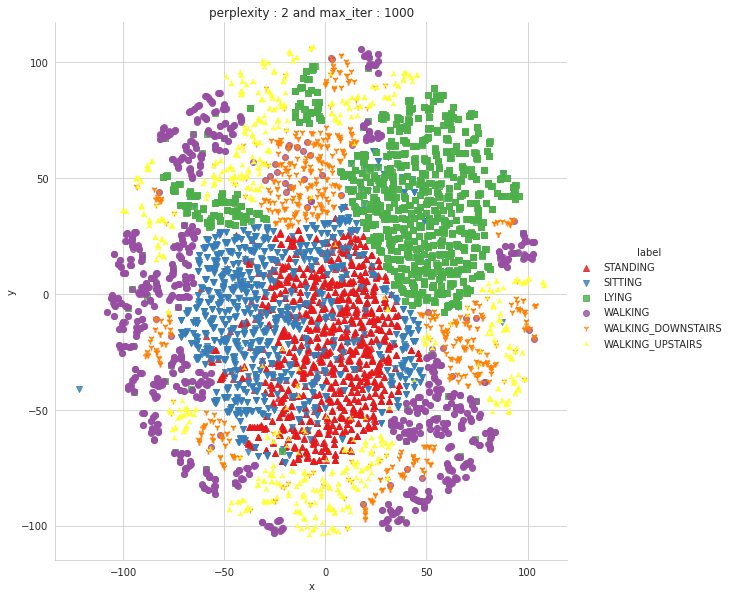

Done

performing tsne with perplexity 5 and with 1000 iterations at max
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 7351 samples in 0.005s...
[t-SNE] Computed neighbors for 7351 samples in 1.846s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7351
[t-SNE] Computed conditional probabilities for sample 2000 / 7351
[t-SNE] Computed conditional probabilities for sample 3000 / 7351
[t-SNE] Computed conditional probabilities for sample 4000 / 7351
[t-SNE] Computed conditional probabilities for sample 5000 / 7351
[t-SNE] Computed conditional probabilities for sample 6000 / 7351
[t-SNE] Computed conditional probabilities for sample 7000 / 7351
[t-SNE] Computed conditional probabilities for sample 7351 / 7351
[t-SNE] Mean sigma: 0.961241
[t-SNE] Computed conditional probabilities in 0.124s
[t-SNE] Iteration 50: error = 114.0489197, gradient norm = 0.0211748 (50 iterations in 10.975s)
[t-SNE] Iteration 100: error = 97.5075531, gradient norm = 0.0163422 (50 iteratio

C:\Users\User\anaconda3\envs\tf-gpu\lib\site-packages\seaborn\regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


saving this plot as image in present working directory...


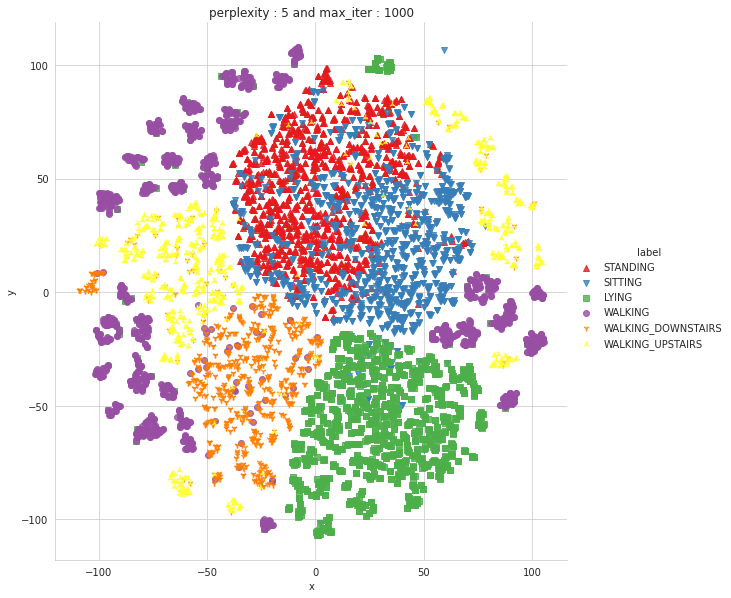

Done

performing tsne with perplexity 10 and with 1000 iterations at max
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 7351 samples in 0.005s...
[t-SNE] Computed neighbors for 7351 samples in 2.566s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7351
[t-SNE] Computed conditional probabilities for sample 2000 / 7351
[t-SNE] Computed conditional probabilities for sample 3000 / 7351
[t-SNE] Computed conditional probabilities for sample 4000 / 7351
[t-SNE] Computed conditional probabilities for sample 5000 / 7351
[t-SNE] Computed conditional probabilities for sample 6000 / 7351
[t-SNE] Computed conditional probabilities for sample 7000 / 7351
[t-SNE] Computed conditional probabilities for sample 7351 / 7351
[t-SNE] Mean sigma: 1.133804
[t-SNE] Computed conditional probabilities in 0.166s
[t-SNE] Iteration 50: error = 105.6233521, gradient norm = 0.0197190 (50 iterations in 13.617s)
[t-SNE] Iteration 100: error = 90.5289993, gradient norm = 0.0181831 (50 iterati

C:\Users\User\anaconda3\envs\tf-gpu\lib\site-packages\seaborn\regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


saving this plot as image in present working directory...


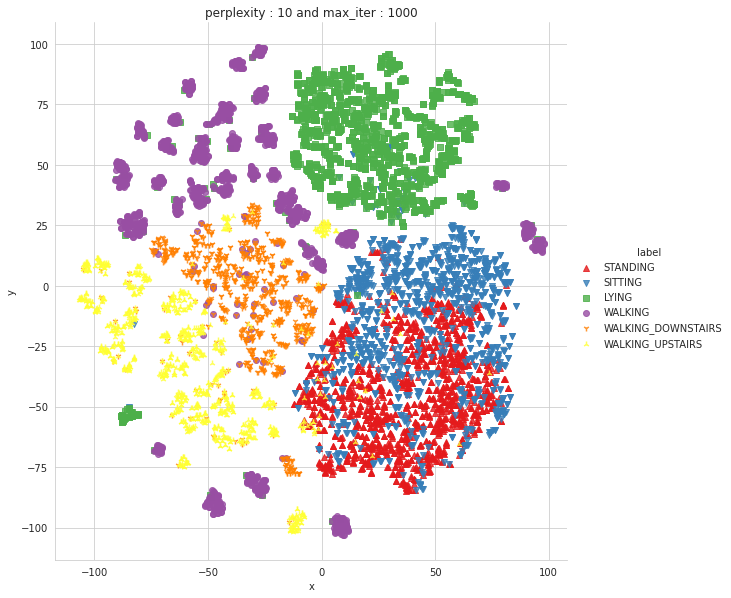

Done

performing tsne with perplexity 20 and with 1000 iterations at max
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 7351 samples in 0.006s...
[t-SNE] Computed neighbors for 7351 samples in 1.616s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7351
[t-SNE] Computed conditional probabilities for sample 2000 / 7351
[t-SNE] Computed conditional probabilities for sample 3000 / 7351
[t-SNE] Computed conditional probabilities for sample 4000 / 7351
[t-SNE] Computed conditional probabilities for sample 5000 / 7351
[t-SNE] Computed conditional probabilities for sample 6000 / 7351
[t-SNE] Computed conditional probabilities for sample 7000 / 7351
[t-SNE] Computed conditional probabilities for sample 7351 / 7351
[t-SNE] Mean sigma: 1.274317
[t-SNE] Computed conditional probabilities in 0.245s
[t-SNE] Iteration 50: error = 97.3378983, gradient norm = 0.0222443 (50 iterations in 9.463s)
[t-SNE] Iteration 100: error = 83.9613800, gradient norm = 0.0074740 (50 iteration

C:\Users\User\anaconda3\envs\tf-gpu\lib\site-packages\seaborn\regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


saving this plot as image in present working directory...


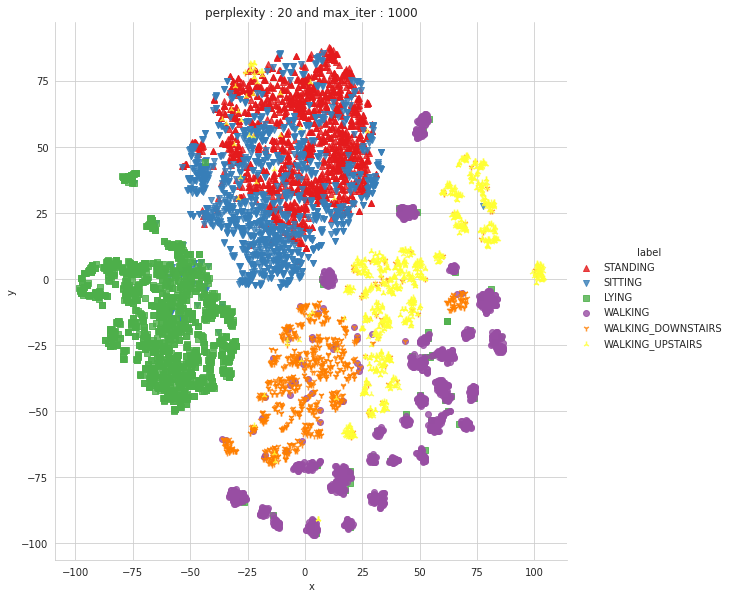

Done

performing tsne with perplexity 50 and with 1000 iterations at max
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 7351 samples in 0.005s...
[t-SNE] Computed neighbors for 7351 samples in 1.537s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7351
[t-SNE] Computed conditional probabilities for sample 2000 / 7351
[t-SNE] Computed conditional probabilities for sample 3000 / 7351
[t-SNE] Computed conditional probabilities for sample 4000 / 7351
[t-SNE] Computed conditional probabilities for sample 5000 / 7351
[t-SNE] Computed conditional probabilities for sample 6000 / 7351
[t-SNE] Computed conditional probabilities for sample 7000 / 7351
[t-SNE] Computed conditional probabilities for sample 7351 / 7351
[t-SNE] Mean sigma: 1.437668
[t-SNE] Computed conditional probabilities in 0.574s
[t-SNE] Iteration 50: error = 85.6197968, gradient norm = 0.0269807 (50 iterations in 3.870s)
[t-SNE] Iteration 100: error = 75.5166855, gradient norm = 0.0041872 (50 iteratio

C:\Users\User\anaconda3\envs\tf-gpu\lib\site-packages\seaborn\regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


saving this plot as image in present working directory...


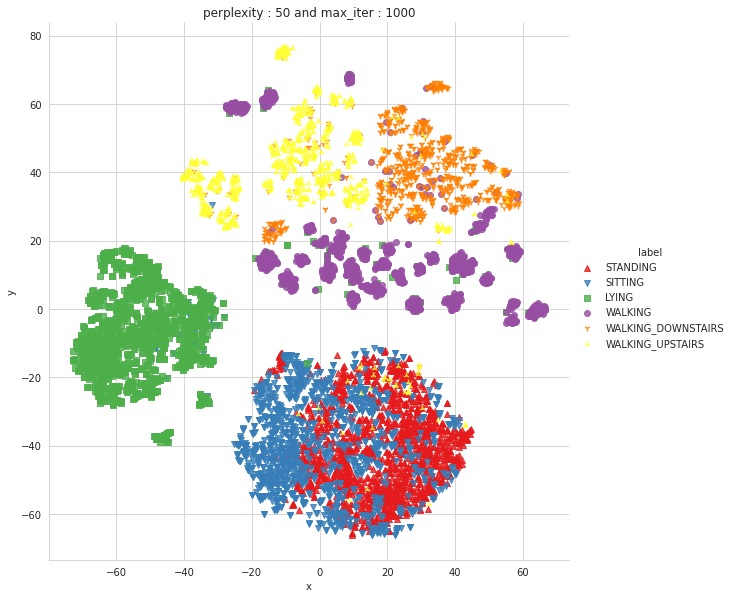

Done


In [ ]:
X_pre_tsne = train.drop(['subject', 'Activity','ActivityName'], axis=1)
y_pre_tsne = train['ActivityName']
perform_tsne(X_data = X_pre_tsne,y_data=y_pre_tsne, perplexities =[2,5,10,20,50])

In [49]:
import numpy as np
import pandas as pd

## Obtain the train and test data

In [50]:
train = pd.read_csv('UCI_HAR_Dataset/csv_files/train.csv')
test = pd.read_csv('UCI_HAR_Dataset/csv_files/test.csv')
print(train.shape, test.shape)

(7351, 564) (2946, 564)


In [51]:
train.head(3)

,tBodyAccmeanX,tBodyAccmeanY,tBodyAccmeanZ,tBodyAccstdX,tBodyAccstdY,tBodyAccstdZ,tBodyAccmadX,tBodyAccmadY,tBodyAccmadZ,tBodyAccmaxX,tBodyAccmaxY,tBodyAccmaxZ,tBodyAccminX,tBodyAccminY,tBodyAccminZ,tBodyAccsma,tBodyAccenergyX,tBodyAccenergyY,tBodyAccenergyZ,tBodyAcciqrX,tBodyAcciqrY,tBodyAcciqrZ,tBodyAccentropyX,tBodyAccentropyY,tBodyAccentropyZ,tBodyAccarCoeffX1,tBodyAccarCoeffX2,tBodyAccarCoeffX3,tBodyAccarCoeffX4,tBodyAccarCoeffY1,tBodyAccarCoeffY2,tBodyAccarCoeffY3,tBodyAccarCoeffY4,tBodyAccarCoeffZ1,tBodyAccarCoeffZ2,tBodyAccarCoeffZ3,tBodyAccarCoeffZ4,tBodyAcccorrelationXY,tBodyAcccorrelationXZ,tBodyAcccorrelationYZ,...,fBodyBodyAccJerkMagmaxInds,fBodyBodyAccJerkMagmeanFreq,fBodyBodyAccJerkMagskewness,fBodyBodyAccJerkMagkurtosis,fBodyBodyGyroMagmean,fBodyBodyGyroMagstd,fBodyBodyGyroMagmad,fBodyBodyGyroMagmax,fBodyBodyGyroMagmin,fBodyBodyGyroMagsma,fBodyBodyGyroMagenergy,fBodyBodyGyroMagiqr,fBodyBodyGyroMagentropy,fBodyBodyGyroMagmaxInds,fBodyBodyGyroMagmeanFreq,fBodyBodyGyroMagskewness,fBodyBodyGyroMagkurtosis,fBodyBodyGyroJerkMagmean,fBodyBodyGyroJerkMagstd,fBodyBodyGyroJerkMagmad,fBodyBodyGyroJerkMagmax,fBodyBodyGyroJerkMagmin,fBodyBodyGyroJerkMagsma,fBodyBodyGyroJerkMagenergy,fBodyBodyGyroJerkMagiqr,fBodyBodyGyroJerkMagentropy,fBodyBodyGyroJerkMagmaxInds,fBodyBodyGyroJerkMagmeanFreq,fBodyBodyGyroJerkMagskewness,fBodyBodyGyroJerkMagkurtosis,angletBodyAccMeangravity,angletBodyAccJerkMeangravityMean,angletBodyGyroMeangravityMean,angletBodyGyroJerkMeangravityMean,angleXgravityMean,angleYgravityMean,angleZgravityMean,subject,Activity,ActivityName
0,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,-0.557851,-0.818409,0.849308,0.685845,0.822637,-0.981930,-0.999991,-0.999788,-0.998405,-0.99915,-0.977866,-0.948225,-0.714892,-0.500930,-0.570979,0.611627,-0.329549,0.284213,0.284595,0.115705,-0.090963,0.294310,-0.281211,0.085988,-0.022153,-0.016657,-0.220643,-0.013429,-0.072692,0.579382,...,-0.841270,0.532061,-0.624871,-0.900160,-0.988296,-0.983322,-0.982659,-0.986321,-0.991829,-0.988296,-0.999811,-0.993979,-0.720683,-0.948718,-0.271958,-0.336310,-0.720015,-0.995854,-0.996399,-0.995442,-0.996866,-0.994440,-0.995854,-0.999981,-0.994544,-1.000000,-1.000000,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,5,STANDING
1,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,-0.557851,-0.818409,0.843609,0.682401,0.839344,-0.983478,-0.999969,-0.999660,-0.999470,-0.99713,-0.964810,-0.974675,-0.592235,-0.485821,-0.570979,0.273025,-0.086309,0.337202,-0.164739,0.017150,-0.074507,0.342256,-0.332564,0.239281,-0.136204,0.173863,-0.299493,-0.124698,-0.181105,0.608900,...,-0.904762,0.660795,-0.724697,-0.928539,-0.989255,-0.986028,-0.984274,-0.990979,-0.995703,-0.989255,-0.999854,-0.993238,-0.736521,-0.794872,-0.212728,-0.535352,-0.871914,-0.995031,-0.995127,-0.994640,-0.996060,-0.995866,-0.995031,-0.999973,-0.993755,-1.000000,-0.555556,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,5,STANDING
2,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,-0.576159,-0.829711,0.843609,0.682401,0.837869,-0.986093,-0.999976,-0.999736,-0.999504,-0.99718,-0.983799,-0.986007,-0.627446,-0.850930,-0.911872,0.061436,0.074840,0.198204,-0.264307,0.072545,-0.155320,0.323154,-0.170813,0.294938,-0.306081,0.482148,-0.470129,-0.305693,-0.362654,0.507459,...,1.000000,0.678921,-0.701131,-0.909639,-0.989413,-0.987836,-0.986850,-0.986749,-0.996199,-0.989413,-0.999876,-0.989136,-0.720891,-1.000000,-0.035684,-0.230091,-0.511217,-0.995221,-0.995237,-0.995722,-0.995273,-0.995732,-0.995221,-0.999974,-0.995226,-0.955696,-0.936508,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,5,STANDING


In [52]:
# get X_train and y_train from csv files
X_train = train.drop(['subject', 'Activity', 'ActivityName'], axis=1)
y_train = train.ActivityName

In [53]:
# get X_test and y_test from test csv file
X_test = test.drop(['subject', 'Activity', 'ActivityName'], axis=1)
y_test = test.ActivityName

In [54]:
print('X_train and y_train : ({},{})'.format(X_train.shape, y_train.shape))
print('X_test  and y_test  : ({},{})'.format(X_test.shape, y_test.shape))

X_train and y_train : ((7351, 561),(7351,))
X_test  and y_test  : ((2946, 561),(2946,))


# Let's model with our data

### Labels that are useful in plotting confusion matrix

In [55]:
labels=['LAYING', 'SITTING','STANDING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']

### Function to plot the confusion matrix

In [56]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
plt.rcParams["font.family"] = 'DejaVu Sans'

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Generic function to run any model specified

In [57]:
from datetime import datetime
def perform_model(model, X_train, y_train, X_test, y_test, class_labels, cm_normalize=True, \
                 print_cm=True, cm_cmap=plt.cm.Greens):
    
    
    # to store results at various phases
    results = dict()
    
    # time at which model starts training 
    train_start_time = datetime.now()
    print('training the model..')
    model.fit(X_train, y_train)
    print('Done \n \n')
    train_end_time = datetime.now()
    results['training_time'] =  train_end_time - train_start_time
    print('training_time(HH:MM:SS.ms) - {}\n\n'.format(results['training_time']))
    
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    print('Done \n \n')
    results['testing_time'] = test_end_time - test_start_time
    print('testing time(HH:MM:SS:ms) - {}\n\n'.format(results['testing_time']))
    results['predicted'] = y_pred
   

    # calculate overall accuracty of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('---------------------')
    print('|      Accuracy      |')
    print('---------------------')
    print('\n    {}\n\n'.format(accuracy))
    
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    if print_cm: 
        print('--------------------')
        print('| Confusion Matrix |')
        print('--------------------')
        print('\n {}'.format(cm))
        
    # plot confusin matrix
    plt.figure(figsize=(8,8))
    plt.grid(b=False)
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized confusion matrix', cmap = cm_cmap)
    plt.show()
    
    # get classification report
    print('-------------------------')
    print('| Classifiction Report |')
    print('-------------------------')
    classification_report = metrics.classification_report(y_test, y_pred)
    # store report in results
    results['classification_report'] = classification_report
    print(classification_report)
    
    # add the trained  model to the results
    results['model'] = model
    
    return results
    
    

### Method to print the gridsearch Attributes

In [58]:
def print_grid_search_attributes(model):
    # Estimator that gave highest score among all the estimators formed in GridSearch
    print('--------------------------')
    print('|      Best Estimator     |')
    print('--------------------------')
    print('\n\t{}\n'.format(model.best_estimator_))


    # parameters that gave best results while performing grid search
    print('--------------------------')
    print('|     Best parameters     |')
    print('--------------------------')
    print('\tParameters of best estimator : \n\n\t{}\n'.format(model.best_params_))


    #  number of cross validation splits
    print('---------------------------------')
    print('|   No of CrossValidation sets   |')
    print('--------------------------------')
    print('\n\tTotal number of cross validation sets: {}\n'.format(model.n_splits_))


    # Average cross validated score of the best estimator, from the Grid Search 
    print('--------------------------')
    print('|        Best Score       |')
    print('--------------------------')
    print('\n\tAverage Cross Validate scores of best estimator : \n\n\t{}\n'.format(model.best_score_))

    
    

# 1. Logistic Regression with Grid Search

In [59]:
from sklearn import linear_model
from sklearn import metrics

from sklearn.model_selection import GridSearchCV

training the model..
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   27.3s finished
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Done 
 

training_time(HH:MM:SS.ms) - 0:00:31.019867


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.011317


---------------------
|      Accuracy      |
---------------------

    0.9107264086897489


--------------------
| Confusion Matrix |
--------------------

 [[519   0   0  18   0   0]
 [ 14 416  59   0   0   2]
 [  0  34 491   2   0   5]
 [  0   0   0 476  15   5]
 [  0   0   2  29 355  34]
 [  0   1   9  19  15 426]]


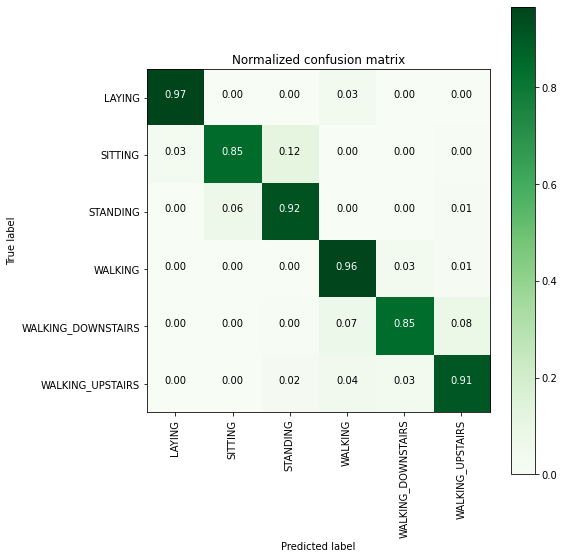

-------------------------
| Classifiction Report |
-------------------------
                    precision    recall  f1-score   support

             LYING       0.97      0.97      0.97       537
           SITTING       0.92      0.85      0.88       491
          STANDING       0.88      0.92      0.90       532
           WALKING       0.88      0.96      0.92       496
WALKING_DOWNSTAIRS       0.92      0.85      0.88       420
  WALKING_UPSTAIRS       0.90      0.91      0.90       470

          accuracy                           0.91      2946
         macro avg       0.91      0.91      0.91      2946
      weighted avg       0.91      0.91      0.91      2946



In [60]:

# start Grid search
parameters = {'C':[0.01, 0.1, 1, 10, 20, 30], 'penalty':['l2','l1']}
log_reg = linear_model.LogisticRegression()
log_reg_grid = GridSearchCV(log_reg, param_grid=parameters, cv=3, verbose=1, n_jobs=-1)
log_reg_grid_results =  perform_model(log_reg_grid, X_train, y_train, X_test, y_test, class_labels=labels)


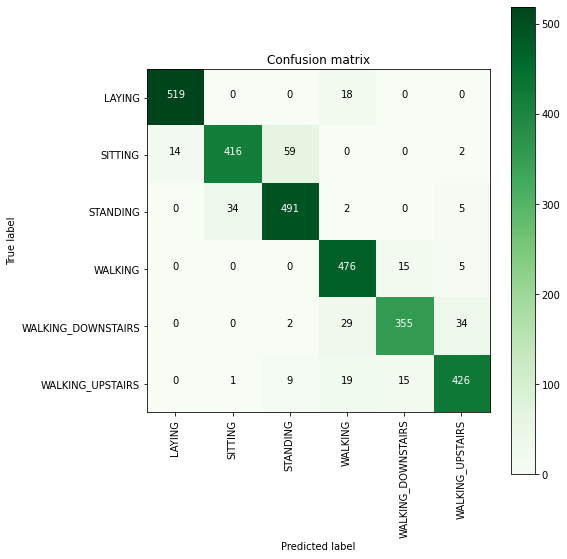

In [61]:
plt.figure(figsize=(8,8))
plt.grid(b=False)
plot_confusion_matrix(log_reg_grid_results['confusion_matrix'], classes=labels, cmap=plt.cm.Greens, )
plt.show()

In [62]:
# observe the attributes of the model 
print_grid_search_attributes(log_reg_grid_results['model'])

--------------------------
|      Best Estimator     |
--------------------------

	LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'C': 0.1, 'penalty': 'l2'}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total number of cross validation sets: 3

--------------------------
|        Best Score       |
--------------------------

	Average Cross Validate scores of best estimator : 

	0.8983807803006963



#  2. Linear SVC with GridSearch

training the model..
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.3min finished
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done 
 

training_time(HH:MM:SS.ms) - 0:03:31.503406


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.011906


---------------------
|      Accuracy      |
---------------------

    0.9212491513917176


--------------------
| Confusion Matrix |
--------------------

 [[509   0  10  18   0   0]
 [ 10 421  54   0   0   6]
 [  0  24 502   1   0   5]
 [  1   1   0 476  13   5]
 [  0   1   2  19 372  26]
 [  0   5   9   9  13 434]]


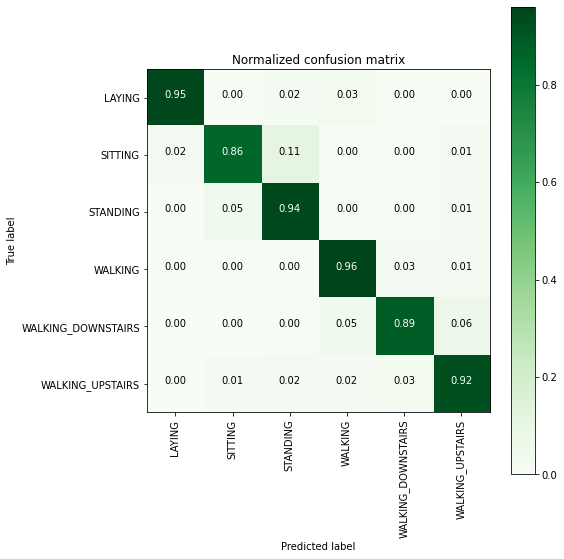

-------------------------
| Classifiction Report |
-------------------------
                    precision    recall  f1-score   support

             LYING       0.98      0.95      0.96       537
           SITTING       0.93      0.86      0.89       491
          STANDING       0.87      0.94      0.91       532
           WALKING       0.91      0.96      0.93       496
WALKING_DOWNSTAIRS       0.93      0.89      0.91       420
  WALKING_UPSTAIRS       0.91      0.92      0.92       470

          accuracy                           0.92      2946
         macro avg       0.92      0.92      0.92      2946
      weighted avg       0.92      0.92      0.92      2946



In [63]:
from sklearn.svm import LinearSVC
parameters = {'C':[0.125, 0.5, 1, 2, 8, 16]}
lr_svc = LinearSVC(tol=0.00005)
lr_svc_grid = GridSearchCV(lr_svc, param_grid=parameters, n_jobs=-1, verbose=1)
lr_svc_grid_results = perform_model(lr_svc_grid, X_train, y_train, X_test, y_test, class_labels=labels)

In [64]:
print_grid_search_attributes(lr_svc_grid_results['model'])

--------------------------
|      Best Estimator     |
--------------------------

	LinearSVC(C=0.125, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=5e-05,
          verbose=0)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'C': 0.125}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total number of cross validation sets: 5

--------------------------
|        Best Score       |
--------------------------

	Average Cross Validate scores of best estimator : 

	0.9054581778326558



# 3.  Kernel SVM with GridSearch

training the model..
Done 
 

training_time(HH:MM:SS.ms) - 0:11:06.557159


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:03.746595


---------------------
|      Accuracy      |
---------------------

    0.9276985743380856


--------------------
| Confusion Matrix |
--------------------

 [[518   1   0  18   0   0]
 [ 14 425  51   0   0   1]
 [  0  18 508   0   0   6]
 [  0   0   0 476  15   5]
 [  0   0   2  10 371  37]
 [  3   0   6  20   6 435]]


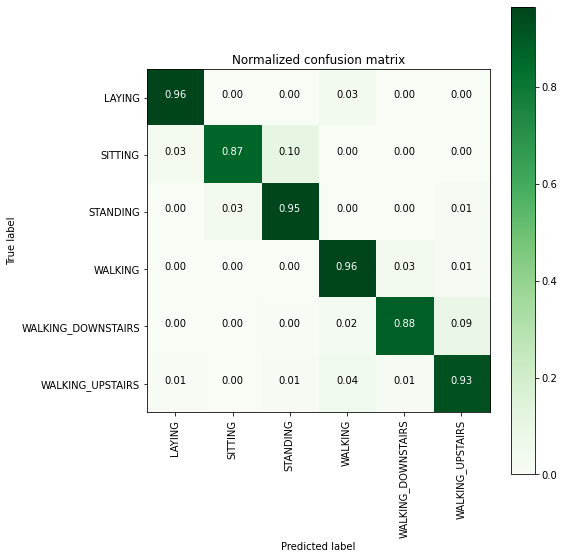

-------------------------
| Classifiction Report |
-------------------------
                    precision    recall  f1-score   support

             LYING       0.97      0.96      0.97       537
           SITTING       0.96      0.87      0.91       491
          STANDING       0.90      0.95      0.92       532
           WALKING       0.91      0.96      0.93       496
WALKING_DOWNSTAIRS       0.95      0.88      0.91       420
  WALKING_UPSTAIRS       0.90      0.93      0.91       470

          accuracy                           0.93      2946
         macro avg       0.93      0.93      0.93      2946
      weighted avg       0.93      0.93      0.93      2946



In [65]:
from sklearn.svm import SVC
parameters = {'C':[2,8,16],\
              'gamma': [ 0.0078125, 0.125, 2]}
rbf_svm = SVC(kernel='rbf')
rbf_svm_grid = GridSearchCV(rbf_svm,param_grid=parameters, n_jobs=-1)
rbf_svm_grid_results = perform_model(rbf_svm_grid, X_train, y_train, X_test, y_test, class_labels=labels)

In [66]:
print_grid_search_attributes(rbf_svm_grid_results['model'])

--------------------------
|      Best Estimator     |
--------------------------

	SVC(C=8, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0078125, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'C': 8, 'gamma': 0.0078125}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total number of cross validation sets: 5

--------------------------
|        Best Score       |
--------------------------

	Average Cross Validate scores of best estimator : 

	0.9015132470391285



# 4. Decision Trees with GridSearchCV

training the model..
Done 
 

training_time(HH:MM:SS.ms) - 0:00:34.367087


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.005714


---------------------
|      Accuracy      |
---------------------

    0.8377460964019009


--------------------
| Confusion Matrix |
--------------------

 [[517   5   0  12   3   0]
 [ 10 371 110   0   0   0]
 [  0  62 470   0   0   0]
 [ 10   0   0 442  33  11]
 [  7   0   2  49 308  54]
 [ 10   0  11  58  31 360]]


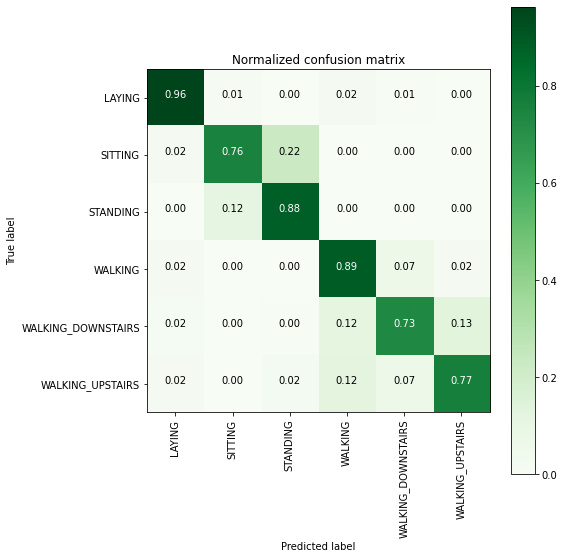

-------------------------
| Classifiction Report |
-------------------------
                    precision    recall  f1-score   support

             LYING       0.93      0.96      0.95       537
           SITTING       0.85      0.76      0.80       491
          STANDING       0.79      0.88      0.84       532
           WALKING       0.79      0.89      0.84       496
WALKING_DOWNSTAIRS       0.82      0.73      0.77       420
  WALKING_UPSTAIRS       0.85      0.77      0.80       470

          accuracy                           0.84      2946
         macro avg       0.84      0.83      0.83      2946
      weighted avg       0.84      0.84      0.84      2946

--------------------------
|      Best Estimator     |
--------------------------

	DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=7, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
          

In [67]:
from sklearn.tree import DecisionTreeClassifier
parameters = {'max_depth':np.arange(3,10,2)}
dt = DecisionTreeClassifier()
dt_grid = GridSearchCV(dt,param_grid=parameters, n_jobs=-1)
dt_grid_results = perform_model(dt_grid, X_train, y_train, X_test, y_test, class_labels=labels)
print_grid_search_attributes(dt_grid_results['model'])

# 5. Random Forest Classifier with GridSearch

training the model..
Done 
 

training_time(HH:MM:SS.ms) - 0:23:42.898764


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.032208


---------------------
|      Accuracy      |
---------------------

    0.8903598099117448


--------------------
| Confusion Matrix |
--------------------

 [[519   0   0  17   1   0]
 [ 13 416  62   0   0   0]
 [  0  46 484   0   0   2]
 [  0   0   0 463  26   7]
 [  0   0   2  30 333  55]
 [  0   0  11  41  10 408]]


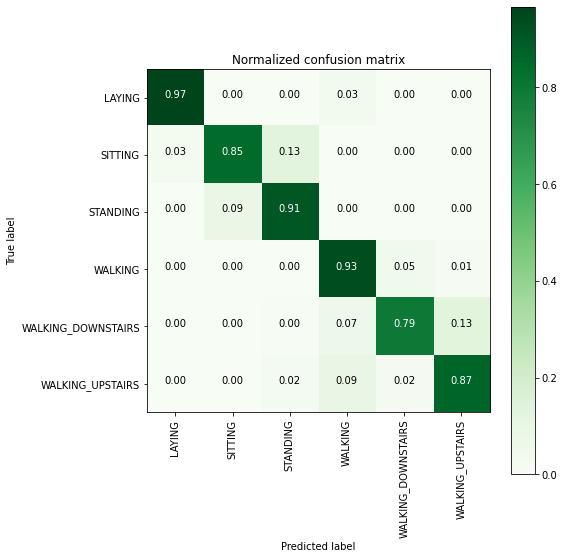

-------------------------
| Classifiction Report |
-------------------------
                    precision    recall  f1-score   support

             LYING       0.98      0.97      0.97       537
           SITTING       0.90      0.85      0.87       491
          STANDING       0.87      0.91      0.89       532
           WALKING       0.84      0.93      0.88       496
WALKING_DOWNSTAIRS       0.90      0.79      0.84       420
  WALKING_UPSTAIRS       0.86      0.87      0.87       470

          accuracy                           0.89      2946
         macro avg       0.89      0.89      0.89      2946
      weighted avg       0.89      0.89      0.89      2946

--------------------------
|      Best Estimator     |
--------------------------

	RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min

In [68]:
from sklearn.ensemble import RandomForestClassifier
params = {'n_estimators': np.arange(10,201,20), 'max_depth':np.arange(3,15,2)}
rfc = RandomForestClassifier()
rfc_grid = GridSearchCV(rfc, param_grid=params, n_jobs=-1)
rfc_grid_results = perform_model(rfc_grid, X_train, y_train, X_test, y_test, class_labels=labels)
print_grid_search_attributes(rfc_grid_results['model'])

# 6.  Gradient Boosted Decision Trees With GridSearch

training the model..
Done 
 

training_time(HH:MM:SS.ms) - 1:17:19.291305


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.030923


---------------------
|      Accuracy      |
---------------------

    0.8917175831636117


--------------------
| Confusion Matrix |
--------------------

 [[518   1   0  18   0   0]
 [ 13 399  73   0   0   6]
 [  0  54 471   0   0   7]
 [  0   2   0 474  17   3]
 [  0   0   2  28 340  50]
 [  0   5   8  20  12 425]]


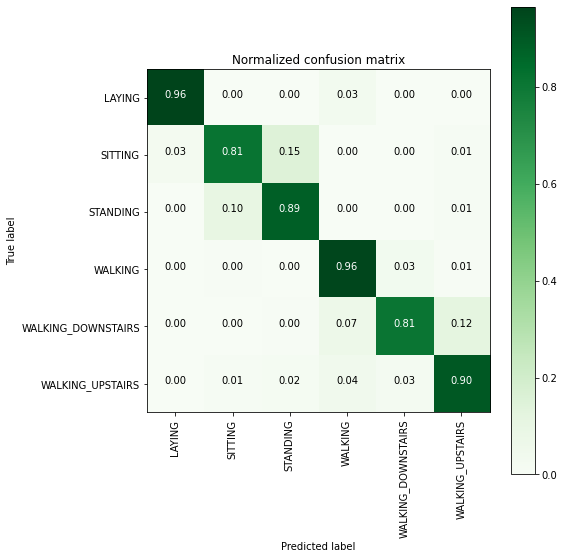

-------------------------
| Classifiction Report |
-------------------------
                    precision    recall  f1-score   support

             LYING       0.98      0.96      0.97       537
           SITTING       0.87      0.81      0.84       491
          STANDING       0.85      0.89      0.87       532
           WALKING       0.88      0.96      0.92       496
WALKING_DOWNSTAIRS       0.92      0.81      0.86       420
  WALKING_UPSTAIRS       0.87      0.90      0.88       470

          accuracy                           0.89      2946
         macro avg       0.89      0.89      0.89      2946
      weighted avg       0.89      0.89      0.89      2946

--------------------------
|      Best Estimator     |
--------------------------

	GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=1,
                           max_features=None, max_leaf_nodes=None,
              

In [69]:
from sklearn.ensemble import GradientBoostingClassifier
param_grid = {'max_depth': np.arange(1,2,3), \
             'n_estimators':np.arange(130,170,10)}
gbdt = GradientBoostingClassifier()
gbdt_grid = GridSearchCV(gbdt, param_grid=param_grid, n_jobs=-1)
gbdt_grid_results = perform_model(gbdt_grid, X_train, y_train, X_test, y_test, class_labels=labels)
print_grid_search_attributes(gbdt_grid_results['model'])


# 7. Comparing all models

In [70]:
print('\n                     Accuracy     Error')
print('                     ----------   --------')
print('Logistic Regression : {:.04}%       {:.04}%'.format(log_reg_grid_results['accuracy'] * 100,\
                                                  100-(log_reg_grid_results['accuracy'] * 100)))

print('Linear SVC          : {:.04}%       {:.04}% '.format(lr_svc_grid_results['accuracy'] * 100,\
                                                        100-(lr_svc_grid_results['accuracy'] * 100)))

print('rbf SVM classifier  : {:.04}%      {:.04}% '.format(rbf_svm_grid_results['accuracy'] * 100,\
                                                          100-(rbf_svm_grid_results['accuracy'] * 100)))

print('DecisionTree        : {:.04}%      {:.04}% '.format(dt_grid_results['accuracy'] * 100,\
                                                        100-(dt_grid_results['accuracy'] * 100)))

print('Random Forest       : {:.04}%      {:.04}% '.format(rfc_grid_results['accuracy'] * 100,\
                                                           100-(rfc_grid_results['accuracy'] * 100)))
print('GradientBoosting DT : {:.04}%      {:.04}% '.format(rfc_grid_results['accuracy'] * 100,\
                                                        100-(rfc_grid_results['accuracy'] * 100)))


                     Accuracy     Error
                     ----------   --------
Logistic Regression : 91.07%       8.927%
Linear SVC          : 92.12%       7.875% 
rbf SVM classifier  : 92.77%      7.23% 
DecisionTree        : 83.77%      16.23% 
Random Forest       : 89.04%      10.96% 
GradientBoosting DT : 89.04%      10.96% 


> We can choose ___Logistic regression___ or ___Linear SVC___ or ___rbf SVM___.

# Conclusion :

In the real world, domain-knowledge, EDA and feature-engineering matter most.

In [ ]:
# Importing Libraries

In [4]:
import pandas as pd
import numpy as np

In [5]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [6]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [7]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).to_numpy()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [8]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]
    print(y)
    return pd.get_dummies(y).to_numpy()

In [9]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [10]:
# Importing tensorflow
np.random.seed(42)
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.set_random_seed(42)

Instructions for updating:
non-resource variables are not supported in the long term


In [11]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [12]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [13]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [14]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

0       5
1       5
2       5
3       5
4       5
       ..
7347    2
7348    2
7349    2
7350    2
7351    2
Name: 0, Length: 7352, dtype: int64
0       5
1       5
2       5
3       5
4       5
       ..
2942    2
2943    2
2944    2
2945    2
2946    2
Name: 0, Length: 2947, dtype: int64


In [15]:
print(Y_train.shape)
print(X_train.shape)
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

(7352, 6)
(7352, 128, 9)
128
9
7352


- Defining the Architecture of LSTM

In [ ]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

# Initializing parameters
n_hidden = 32
epochs = 30
batch_size = 16

# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)


Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - ETA: 0s - loss: 1.2273 - acc: 0.4780- ETA: 2

C:\Users\User\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


7352/7352 [==============================] - 25s 3ms/sample - loss: 1.2273 - acc: 0.4780 - val_loss: 1.0848 - val_acc: 0.5273
Epoch 2/30
7352/7352 [==============================] - 24s 3ms/sample - loss: 0.8313 - acc: 0.6400 - val_loss: 0.7932 - val_acc: 0.6617
Epoch 3/30
7352/7352 [==============================] - 24s 3ms/sample - loss: 0.6082 - acc: 0.7516 - val_loss: 0.6308 - val_acc: 0.7645
Epoch 4/30
7352/7352 [==============================] - 25s 3ms/sample - loss: 0.4933 - acc: 0.7958 - val_loss: 0.7729 - val_acc: 0.7353
Epoch 5/30
7352/7352 [==============================] - 24s 3ms/sample - loss: 0.4237 - acc: 0.8256 - val_loss: 0.5815 - val_acc: 0.7995
Epoch 6/30
7352/7352 [==============================] - 24s 3ms/sample - loss: 0.3601 - acc: 0.8712 - val_loss: 0.4826 - val_acc: 0.8422
Epoch 7/30
7352/7352 [==============================] - 24s 3ms/sample - loss: 0.2594 - acc: 0.9181 - val_loss: 0.4086 - val_acc: 0.8775
Epoch 8/30
7352/7352 [==============================

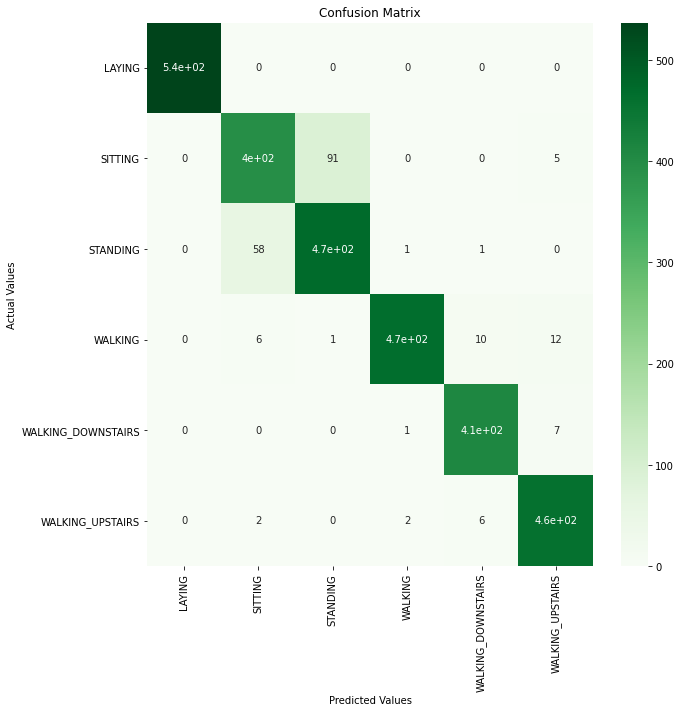

In [ ]:
# Confusion Matrix
# # print(confusion_matrix(Y_test, model.predict(X_test)))
# conf = pd.DataFrame(confusion_matrix(Y_test, model.predict(X_test)))
# conf

import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(Y_test, model.predict(X_test))
cm_df = pd.DataFrame(cm,
                     index = ['LAYING','SITTING','STANDING', 'WALKING', 'WALKING_DOWNSTAIRS','WALKING_UPSTAIRS'], 
                     columns = ['LAYING','SITTING','STANDING', 'WALKING', 'WALKING_DOWNSTAIRS','WALKING_UPSTAIRS'])
#Plotting the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True,cmap = plt.cm.Greens)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
score = model.evaluate(X_test, Y_test)

In [ ]:
score

[0.32405202787081017, 0.9311164]

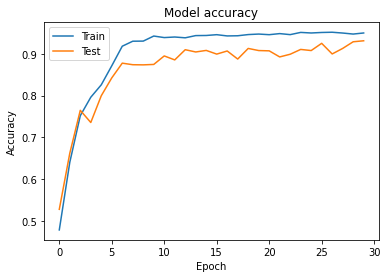

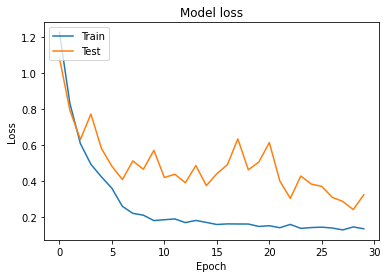

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

1. With a simple 2 layer architecture we got 90.09% accuracy and a loss of 0.27
2. We can further imporve the performace with Hyperparameter tuning

### LSTM with hyper-parameter tuning
#### 1-Layer LSTM Layer with hidden layer = 128 with dropout = 0.5


In [ ]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 128

In [ ]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))


# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - ETA: 0s - loss: 1.0640 - acc: 0.5541

C:\Users\User\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


7352/7352 [==============================] - 82s 11ms/sample - loss: 1.0640 - acc: 0.5541 - val_loss: 0.7268 - val_acc: 0.7027
Epoch 2/30
7352/7352 [==============================] - 82s 11ms/sample - loss: 0.6002 - acc: 0.7696 - val_loss: 0.7891 - val_acc: 0.7414
Epoch 3/30
7352/7352 [==============================] - 81s 11ms/sample - loss: 0.3874 - acc: 0.8674 - val_loss: 0.2840 - val_acc: 0.9050
Epoch 4/30
7352/7352 [==============================] - 81s 11ms/sample - loss: 0.2592 - acc: 0.9128 - val_loss: 0.2904 - val_acc: 0.9043
Epoch 5/30
7352/7352 [==============================] - 81s 11ms/sample - loss: 0.2158 - acc: 0.9232 - val_loss: 0.3819 - val_acc: 0.8897
Epoch 6/30
7352/7352 [==============================] - 81s 11ms/sample - loss: 0.1928 - acc: 0.9321 - val_loss: 0.3848 - val_acc: 0.8948
Epoch 7/30
7352/7352 [==============================] - 81s 11ms/sample - loss: 0.1765 - acc: 0.9344 - val_loss: 0.3138 - val_acc: 0.9030
Epoch 8/30
7352/7352 [=======================

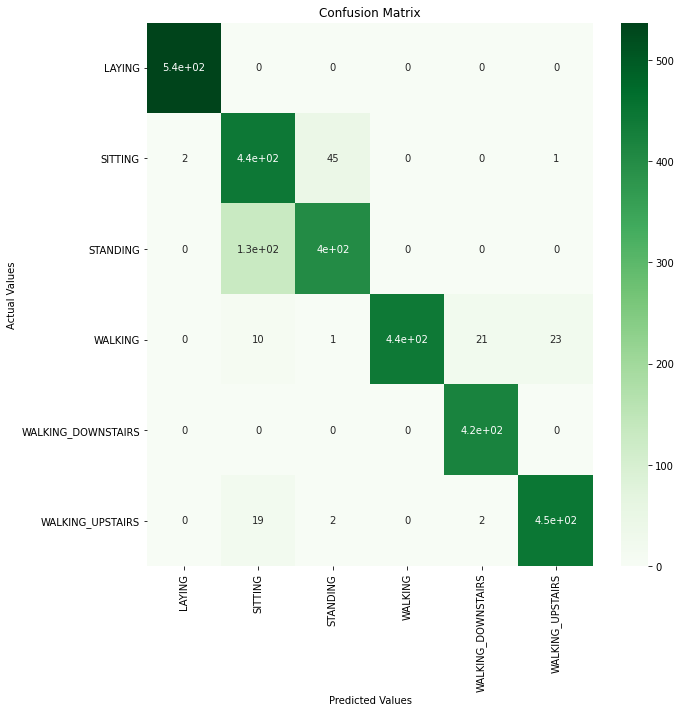

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(Y_test, model.predict(X_test))
cm_df = pd.DataFrame(cm,
                     index = ['LAYING','SITTING','STANDING', 'WALKING', 'WALKING_DOWNSTAIRS','WALKING_UPSTAIRS'], 
                     columns = ['LAYING','SITTING','STANDING', 'WALKING', 'WALKING_DOWNSTAIRS','WALKING_UPSTAIRS'])
#Plotting the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True,cmap = plt.cm.Greens)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
score = model.evaluate(X_test, Y_test,verbose=0)
score

[0.5438593195437598, 0.9127927]

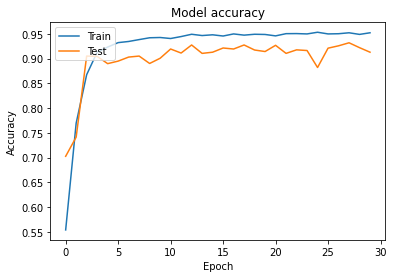

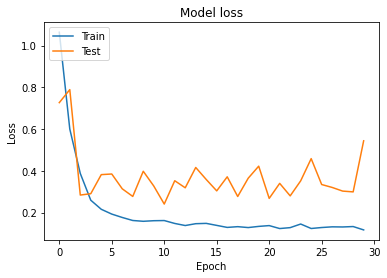

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#### 1-Layer LSTM Layer with hidden layer = 324 with slight change in dropout = 0.6

In [ ]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 324
drop_out_rate = 0.6

In [ ]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.6))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))


# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - ETA: 0s - loss: 1.1203 - acc: 0.5384

C:\Users\User\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


7352/7352 [==============================] - 469s 64ms/sample - loss: 1.1203 - acc: 0.5384 - val_loss: 0.9492 - val_acc: 0.6410
Epoch 2/30
7352/7352 [==============================] - 460s 63ms/sample - loss: 0.7139 - acc: 0.7218 - val_loss: 0.8197 - val_acc: 0.7465
Epoch 3/30
7352/7352 [==============================] - 460s 63ms/sample - loss: 0.5028 - acc: 0.8213 - val_loss: 0.6494 - val_acc: 0.7469
Epoch 4/30
7352/7352 [==============================] - 462s 63ms/sample - loss: 0.3261 - acc: 0.8921 - val_loss: 0.3976 - val_acc: 0.8653
Epoch 5/30
7352/7352 [==============================] - 459s 62ms/sample - loss: 0.2320 - acc: 0.9211 - val_loss: 0.3965 - val_acc: 0.8521
Epoch 6/30
7352/7352 [==============================] - 459s 62ms/sample - loss: 0.2237 - acc: 0.9230 - val_loss: 0.4558 - val_acc: 0.8721
Epoch 7/30
7352/7352 [==============================] - 463s 63ms/sample - loss: 0.1904 - acc: 0.9334 - val_loss: 0.3706 - val_acc: 0.9026
Epoch 8/30
7352/7352 [================

In [ ]:
score = model.evaluate(X_test, Y_test)
score

[0.5354521053017849, 0.90295213]

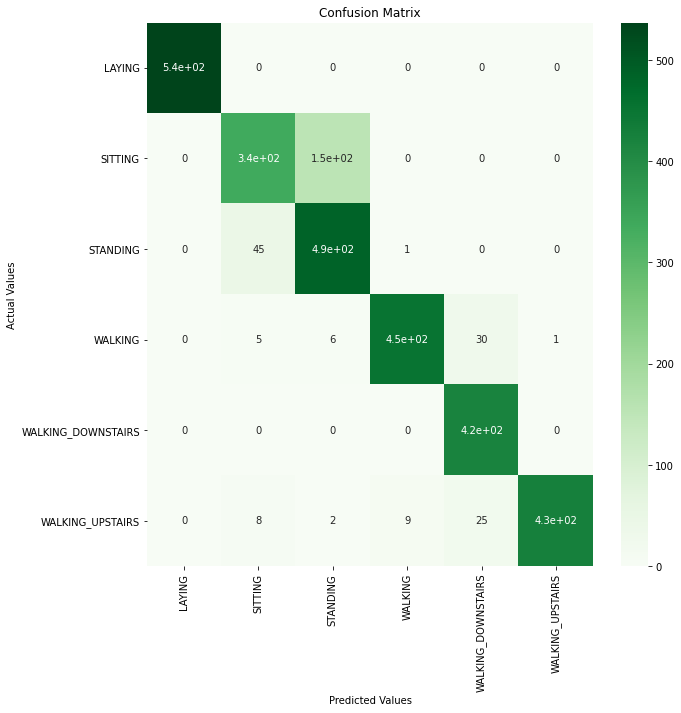

In [ ]:
cm = confusion_matrix(Y_test, model.predict(X_test))
cm_df = pd.DataFrame(cm,
                     index = ['LAYING','SITTING','STANDING', 'WALKING', 'WALKING_DOWNSTAIRS','WALKING_UPSTAIRS'], 
                     columns = ['LAYING','SITTING','STANDING', 'WALKING', 'WALKING_DOWNSTAIRS','WALKING_UPSTAIRS'])
#Plotting the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True,cmap = plt.cm.Greens)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

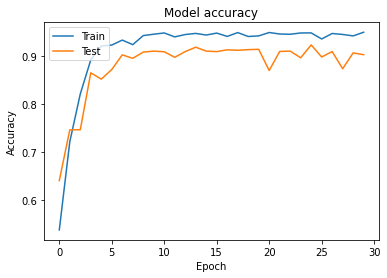

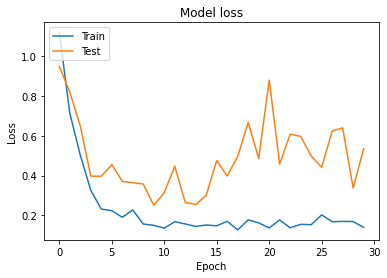

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#### 2-Layer LSTM Layer with hidden layer, h1 = 256 & h2 = 128 with dropout 0.7 & 0.6 respectively

In [ ]:
# Initializing parameters
epochs = 30
batch_size = 16
hidden_layer_1 = 256
hidden_layer_2 = 128

In [ ]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(hidden_layer_1, return_sequences=True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.7))
# Adding a dense output layer with sigmoid activation

model.add(LSTM(hidden_layer_2, input_shape=(timesteps, input_dim)))
model.add(Dropout(0.6))

model.add(Dense(n_classes, activation='sigmoid'))


# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - ETA: 0s - loss: 0.9313 - acc: 0.5958

C:\Users\User\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


7352/7352 [==============================] - 430s 59ms/sample - loss: 0.9313 - acc: 0.5958 - val_loss: 0.8385 - val_acc: 0.6125
Epoch 2/30
7352/7352 [==============================] - 428s 58ms/sample - loss: 0.6077 - acc: 0.7583 - val_loss: 0.4091 - val_acc: 0.8643
Epoch 3/30
7352/7352 [==============================] - 431s 59ms/sample - loss: 0.2532 - acc: 0.9135 - val_loss: 0.3155 - val_acc: 0.8992
Epoch 4/30
7352/7352 [==============================] - 431s 59ms/sample - loss: 0.1926 - acc: 0.9310 - val_loss: 0.2732 - val_acc: 0.9104
Epoch 5/30
7352/7352 [==============================] - 429s 58ms/sample - loss: 0.2102 - acc: 0.9331 - val_loss: 0.2956 - val_acc: 0.9074
Epoch 6/30
7352/7352 [==============================] - 430s 58ms/sample - loss: 0.2105 - acc: 0.9293 - val_loss: 0.3328 - val_acc: 0.9060
Epoch 7/30
7352/7352 [==============================] - 430s 59ms/sample - loss: 0.1671 - acc: 0.9384 - val_loss: 0.4999 - val_acc: 0.8806
Epoch 8/30
7352/7352 [================

In [ ]:
score = model.evaluate(X_test, Y_test)
score

[0.40641000302705177, 0.92229384]

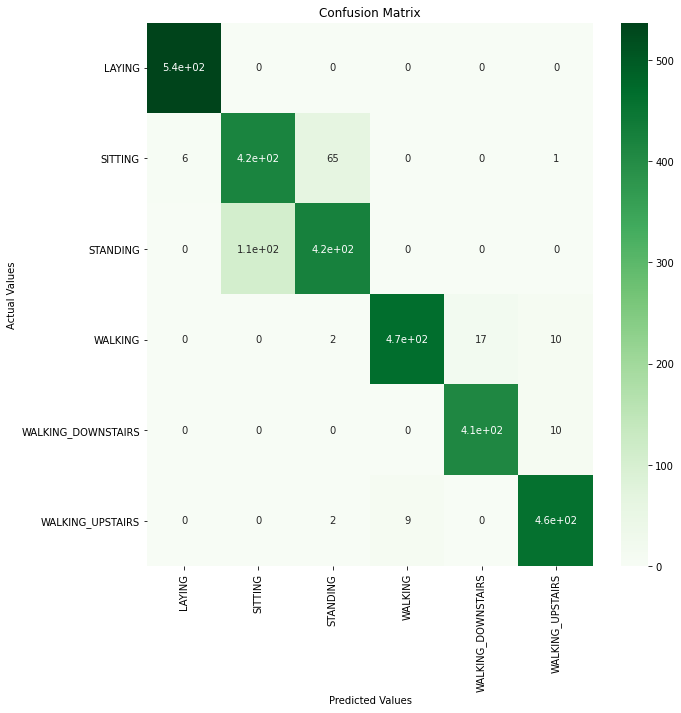

In [ ]:
cm = confusion_matrix(Y_test, model.predict(X_test))
cm_df = pd.DataFrame(cm,
                     index = ['LAYING','SITTING','STANDING', 'WALKING', 'WALKING_DOWNSTAIRS','WALKING_UPSTAIRS'], 
                     columns = ['LAYING','SITTING','STANDING', 'WALKING', 'WALKING_DOWNSTAIRS','WALKING_UPSTAIRS'])
#Plotting the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True,cmap = plt.cm.Greens)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

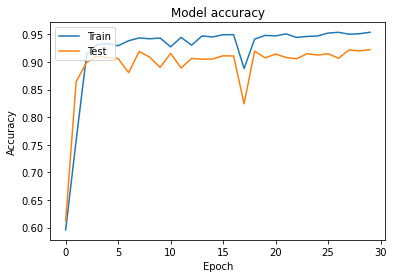

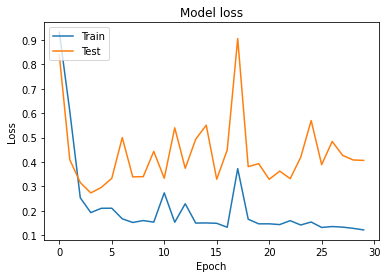

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#### 2-Layer LSTM Layer with hidden layer, h1 = 128 & h2 = 64 with dropout 0.2 & 0.5 respectively.

In [ ]:
epochs = 30
batch_size = 32
n_hidden1 = 128
n_hidden2 =64

In [ ]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden1, return_sequences=True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.2))
# Adding a dense output layer with sigmoid activation

model.add(LSTM(n_hidden2, input_shape=(timesteps, input_dim)))
model.add(Dropout(0.5))

model.add(Dense(n_classes, activation='sigmoid'))


# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - ETA: 0s - loss: 0.9387 - acc: 0.6159

C:\Users\User\anaconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


7352/7352 [==============================] - 76s 10ms/sample - loss: 0.9387 - acc: 0.6159 - val_loss: 0.6632 - val_acc: 0.7822
Epoch 2/30
7352/7352 [==============================] - 76s 10ms/sample - loss: 0.4829 - acc: 0.8350 - val_loss: 0.5659 - val_acc: 0.7971
Epoch 3/30
7352/7352 [==============================] - 75s 10ms/sample - loss: 0.2953 - acc: 0.9013 - val_loss: 0.4871 - val_acc: 0.8612
Epoch 4/30
7352/7352 [==============================] - 75s 10ms/sample - loss: 0.2382 - acc: 0.9203 - val_loss: 0.4891 - val_acc: 0.8398
Epoch 5/30
7352/7352 [==============================] - 75s 10ms/sample - loss: 0.1829 - acc: 0.9339 - val_loss: 0.4561 - val_acc: 0.8765
Epoch 6/30
7352/7352 [==============================] - 75s 10ms/sample - loss: 0.1644 - acc: 0.9389 - val_loss: 0.4542 - val_acc: 0.8894
Epoch 7/30
7352/7352 [==============================] - 75s 10ms/sample - loss: 0.1418 - acc: 0.9434 - val_loss: 0.5123 - val_acc: 0.8894
Epoch 8/30
7352/7352 [=======================

In [ ]:
score = model.evaluate(X_test, Y_test)
score

[0.43037211129663694, 0.9307771]

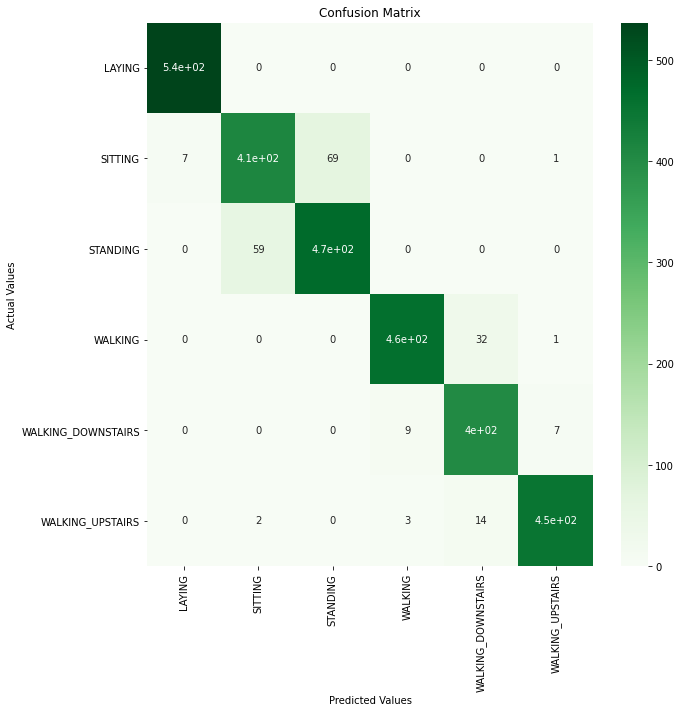

In [ ]:
cm = confusion_matrix(Y_test, model.predict(X_test))
cm_df = pd.DataFrame(cm,
                     index = ['LAYING','SITTING','STANDING', 'WALKING', 'WALKING_DOWNSTAIRS','WALKING_UPSTAIRS'], 
                     columns = ['LAYING','SITTING','STANDING', 'WALKING', 'WALKING_DOWNSTAIRS','WALKING_UPSTAIRS'])
#Plotting the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True,cmap = plt.cm.Greens)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

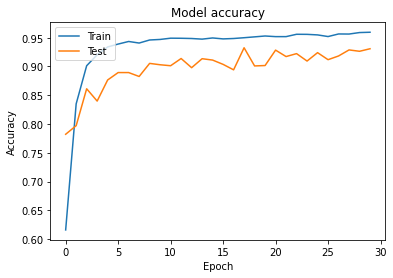

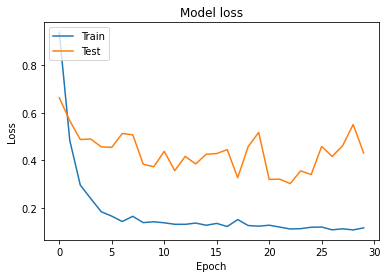

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [10]:
from prettytable import PrettyTable 

x = PrettyTable()
x.field_names = ["LSTM layer.", "Architecture",  "Test Loss(Cross-Entropy)", "Test Accuracy"]
x.add_row(["1", "32 hiddenlayer(0.5 dropout)", 0.324, 0.93 ])
x.add_row(["1", "128 hiddenlayer(0.5 dropout)", 0.54, 0.912 ])
x.add_row(["2", "324 hiddenlayer(0.6 dropout)", 0.53, 0.901])
x.add_row(["2", "256 hiddenlayer(0.7 dropout) and 128 hiddenlayer(0.6 dropout)", 0.40, 0.901 ])
x.add_row(["2",  "128 hiddenlayer(0.2 dropout) and 64 hiddenlayer(0.5 dropout)", 0.43, 0.93 ])
print(x)

+-------------+---------------------------------------------------------------+--------------------------+---------------+
| LSTM layer. |                          Architecture                         | Test Loss(Cross-Entropy) | Test Accuracy |
+-------------+---------------------------------------------------------------+--------------------------+---------------+
|      1      |                  32 hiddenlayer(0.5 dropout)                  |          0.324           |      0.93     |
|      1      |                  128 hiddenlayer(0.5 dropout)                 |           0.54           |     0.912     |
|      2      |                  324 hiddenlayer(0.6 dropout)                 |           0.53           |     0.901     |
|      2      | 256 hiddenlayer(0.7 dropout) and 128 hiddenlayer(0.6 dropout) |           0.4            |     0.901     |
|      2      |  128 hiddenlayer(0.2 dropout) and 64 hiddenlayer(0.5 dropout) |           0.43           |      0.93     |
+-------------+-

## CNN + LSTM

### 3 Conv Layers Without Dropout and Batchnormalization

In [16]:
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing import sequence
from keras.initializers import RandomNormal
from keras.initializers import glorot_uniform,glorot_normal 
from keras.layers import BatchNormalization

In [17]:
input_shape = (timesteps, input_dim, 1)
X_train = X_train.reshape(X_train.shape[0], timesteps, input_dim, 1)
X_test = X_test.reshape(X_test.shape[0], timesteps, input_dim, 1)

In [18]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(5, 5),activation='relu', padding='same', input_shape=input_shape))

model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model.summary()
history = model.fit(X_train, Y_train, batch_size=256, epochs=30, verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 9, 64)        1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 9, 32)        18464     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 9, 32)        9248      
_________________________________________________________________
flatten (Flatten)            (None, 36864)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               3686500   
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
__________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


7352/7352 [==============================] - 33s 4ms/sample - loss: 0.5888 - acc: 0.7845 - val_loss: 1.3936 - val_acc: 0.2131
Epoch 2/30
7352/7352 [==============================] - 2s 332us/sample - loss: 0.2156 - acc: 0.9332 - val_loss: 1.0097 - val_acc: 0.6474
Epoch 3/30
7352/7352 [==============================] - 2s 334us/sample - loss: 0.1615 - acc: 0.9468 - val_loss: 0.7585 - val_acc: 0.7564
Epoch 4/30
7352/7352 [==============================] - 2s 331us/sample - loss: 0.1420 - acc: 0.9504 - val_loss: 0.5889 - val_acc: 0.8588
Epoch 5/30
7352/7352 [==============================] - 2s 331us/sample - loss: 0.1252 - acc: 0.9548 - val_loss: 0.4899 - val_acc: 0.8799
Epoch 6/30
7352/7352 [==============================] - 2s 333us/sample - loss: 0.1238 - acc: 0.9514 - val_loss: 0.3845 - val_acc: 0.8609
Epoch 7/30
7352/7352 [==============================] - 2s 330us/sample - loss: 0.1141 - acc: 0.9554 - val_loss: 0.3490 - val_acc: 0.8795
Epoch 8/30
7352/7352 [========================

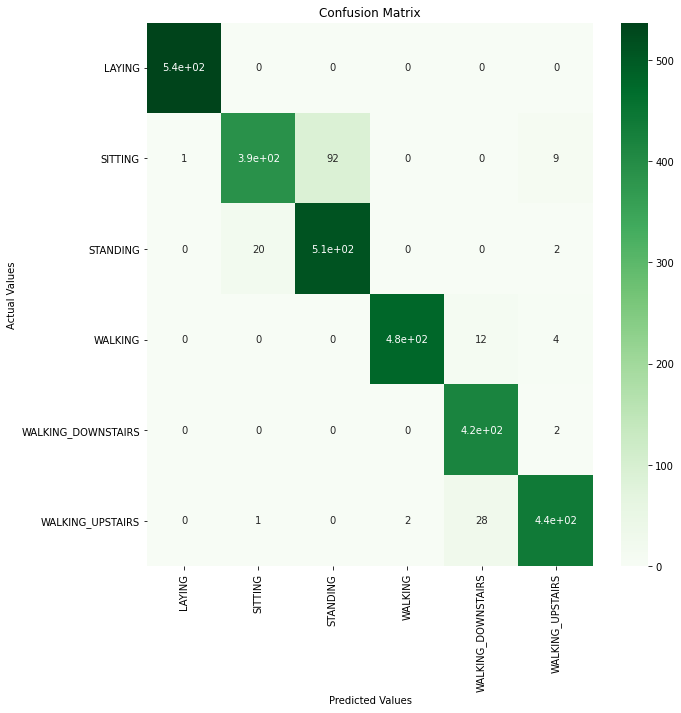

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(Y_test, model.predict(X_test))
cm_df = pd.DataFrame(cm,
                     index = ['LAYING','SITTING','STANDING', 'WALKING', 'WALKING_DOWNSTAIRS','WALKING_UPSTAIRS'], 
                     columns = ['LAYING','SITTING','STANDING', 'WALKING', 'WALKING_DOWNSTAIRS','WALKING_UPSTAIRS'])
#Plotting the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True,cmap = plt.cm.Greens)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

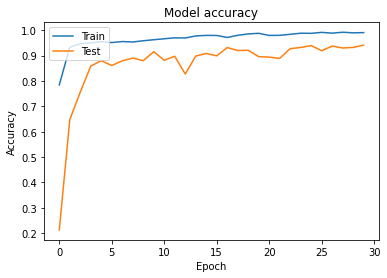

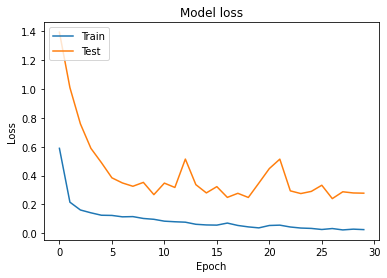

In [21]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### 3 Conv Layers with dropout and Batchnormalization

In [22]:
model = Sequential()
model.add(Conv2D(128, kernel_size=(5, 5),activation='relu', padding='same', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides = 2))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides = 2))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides = 2))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model.summary()
history = model.fit(X_train, Y_train, batch_size=256, epochs=30, verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 9, 128)       3328      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 4, 128)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 4, 128)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 4, 64)         73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 2, 64)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 2, 64)         36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 1, 64)        

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


7352/7352 [==============================] - 4s 510us/sample - loss: 0.8924 - acc: 0.6170 - val_loss: 1.4633 - val_acc: 0.1720
Epoch 2/30
7352/7352 [==============================] - 2s 256us/sample - loss: 0.4894 - acc: 0.8124 - val_loss: 1.1095 - val_acc: 0.8344
Epoch 3/30
7352/7352 [==============================] - 2s 252us/sample - loss: 0.2906 - acc: 0.9027 - val_loss: 0.9228 - val_acc: 0.8806
Epoch 4/30
7352/7352 [==============================] - 2s 253us/sample - loss: 0.2107 - acc: 0.9306 - val_loss: 0.8101 - val_acc: 0.8911
Epoch 5/30
7352/7352 [==============================] - 2s 253us/sample - loss: 0.1668 - acc: 0.9422 - val_loss: 0.6572 - val_acc: 0.9050
Epoch 6/30
7352/7352 [==============================] - 2s 253us/sample - loss: 0.1521 - acc: 0.9478 - val_loss: 0.5645 - val_acc: 0.9094
Epoch 7/30
7352/7352 [==============================] - 2s 251us/sample - loss: 0.1428 - acc: 0.9490 - val_loss: 0.4822 - val_acc: 0.9070
Epoch 8/30
7352/7352 [=======================

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


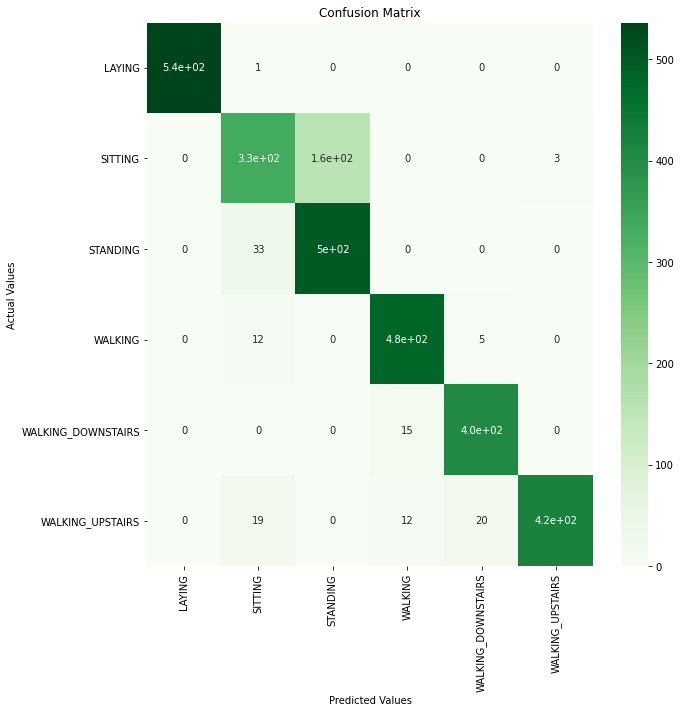

In [23]:
cm = confusion_matrix(Y_test, model.predict(X_test))
cm_df = pd.DataFrame(cm,
                     index = ['LAYING','SITTING','STANDING', 'WALKING', 'WALKING_DOWNSTAIRS','WALKING_UPSTAIRS'], 
                     columns = ['LAYING','SITTING','STANDING', 'WALKING', 'WALKING_DOWNSTAIRS','WALKING_UPSTAIRS'])
#Plotting the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True,cmap = plt.cm.Greens)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

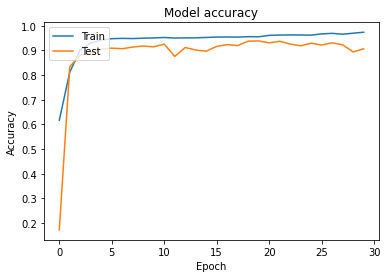

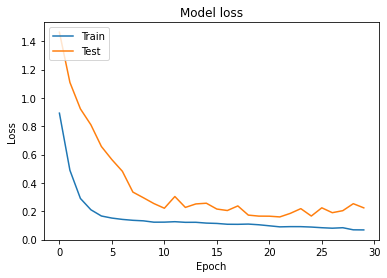

In [24]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### 4 Conv Layers with Dropout,Batchnormalization, Maxpool

In [28]:
model_1 = Sequential()
model_1.add(Conv2D(128, kernel_size=(5, 5),activation='relu', padding='same', input_shape=input_shape))
model_1.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2), strides = 2))
model_1.add(Dropout(0.6))

model_1.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model_1.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2), strides = 2))
model_1.add(BatchNormalization())
model_1.add(Dropout(0.7))

model_1.add(Flatten())
model_1.add(Dense(100, activation='relu'))
model_1.add(BatchNormalization())
model_1.add(Dropout(0.5))
model_1.add(Dense(n_classes, activation='softmax'))

model_1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model_1.summary()
history_1 = model_1.fit(X_train, Y_train, batch_size=256, epochs=30, verbose=1, validation_data=(X_test, Y_test))
score_1 = model_1.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score_1[0])
print('Test accuracy:', score_1[1])


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 128, 9, 128)       3328      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 9, 128)       409728    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 4, 128)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64, 4, 128)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 4, 64)         204864    
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 4, 64)         102464    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 2, 64)        

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


7352/7352 [==============================] - 20s 3ms/sample - loss: 1.2460 - acc: 0.5385 - val_loss: 7.0826 - val_acc: 0.1425
Epoch 2/30
7352/7352 [==============================] - 10s 1ms/sample - loss: 0.7035 - acc: 0.7096 - val_loss: 3.1146 - val_acc: 0.1690
Epoch 3/30
7352/7352 [==============================] - 10s 1ms/sample - loss: 0.4809 - acc: 0.8134 - val_loss: 0.6533 - val_acc: 0.7615
Epoch 4/30
7352/7352 [==============================] - 10s 1ms/sample - loss: 0.3323 - acc: 0.8713 - val_loss: 1.2555 - val_acc: 0.4316
Epoch 5/30
7352/7352 [==============================] - 10s 1ms/sample - loss: 0.2160 - acc: 0.9169 - val_loss: 1.1703 - val_acc: 0.4503
Epoch 6/30
7352/7352 [==============================] - 10s 1ms/sample - loss: 0.1692 - acc: 0.9391 - val_loss: 1.1727 - val_acc: 0.4812
Epoch 7/30
7352/7352 [==============================] - 10s 1ms/sample - loss: 0.1551 - acc: 0.9400 - val_loss: 1.4779 - val_acc: 0.4082
Epoch 8/30
7352/7352 [==============================

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


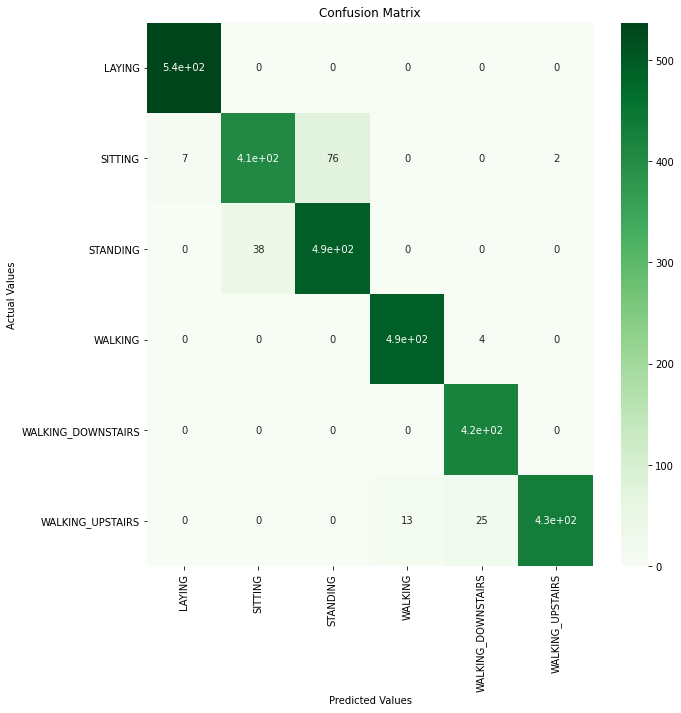

In [29]:
cm = confusion_matrix(Y_test, model_1.predict(X_test))
cm_df = pd.DataFrame(cm,
                     index = ['LAYING','SITTING','STANDING', 'WALKING', 'WALKING_DOWNSTAIRS','WALKING_UPSTAIRS'], 
                     columns = ['LAYING','SITTING','STANDING', 'WALKING', 'WALKING_DOWNSTAIRS','WALKING_UPSTAIRS'])
#Plotting the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True,cmap = plt.cm.Greens)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

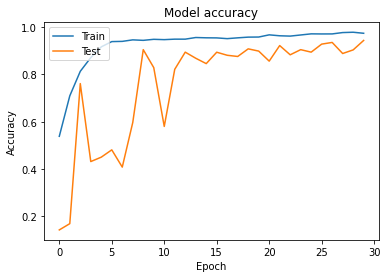

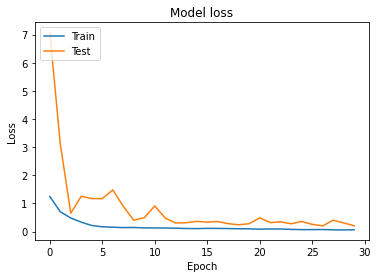

In [30]:
# Plot training & validation accuracy values
plt.plot(history_1.history['acc'])
plt.plot(history_1.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Plot training & validation loss values
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### 4 Conv Layers with Dropout,Bathnormalization, Maxpool

In [31]:
model_2 = Sequential()
model_2.add(Conv2D(64, kernel_size=(5, 5),activation='relu', padding='same', input_shape=input_shape))
model_2.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(2, 2), strides = 2))
model_2.add(Dropout(0.5))

model_2.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
model_2.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(2, 2), strides = 2))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.5))

model_2.add(Flatten())
model_2.add(Dense(100, activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.5))
model_2.add(Dense(n_classes, activation='softmax'))

model_2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model_2.summary()
history_2 = model_2.fit(X_train, Y_train, batch_size=256, epochs=30, verbose=1, validation_data=(X_test, Y_test))
score_2 = model_2.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score_2[0])
print('Test accuracy:', score_2[1])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 128, 9, 64)        1664      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 128, 9, 64)        102464    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 4, 64)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 64, 4, 64)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 4, 32)         51232     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 4, 32)         25632     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 2, 32)        

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


7352/7352 [==============================] - 9s 1ms/sample - loss: 1.0225 - acc: 0.6219 - val_loss: 2.0352 - val_acc: 0.2257
Epoch 2/30
7352/7352 [==============================] - 4s 562us/sample - loss: 0.5125 - acc: 0.7984 - val_loss: 1.1835 - val_acc: 0.6352
Epoch 3/30
7352/7352 [==============================] - 4s 563us/sample - loss: 0.2697 - acc: 0.9022 - val_loss: 1.2261 - val_acc: 0.4506
Epoch 4/30
7352/7352 [==============================] - 4s 563us/sample - loss: 0.2032 - acc: 0.9251 - val_loss: 1.1711 - val_acc: 0.4863
Epoch 5/30
7352/7352 [==============================] - 4s 562us/sample - loss: 0.1567 - acc: 0.9438 - val_loss: 1.2284 - val_acc: 0.4703
Epoch 6/30
7352/7352 [==============================] - 4s 563us/sample - loss: 0.1530 - acc: 0.9407 - val_loss: 1.3482 - val_acc: 0.4116
Epoch 7/30
7352/7352 [==============================] - 4s 562us/sample - loss: 0.1441 - acc: 0.9418 - val_loss: 1.1243 - val_acc: 0.4815
Epoch 8/30
7352/7352 [=========================

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


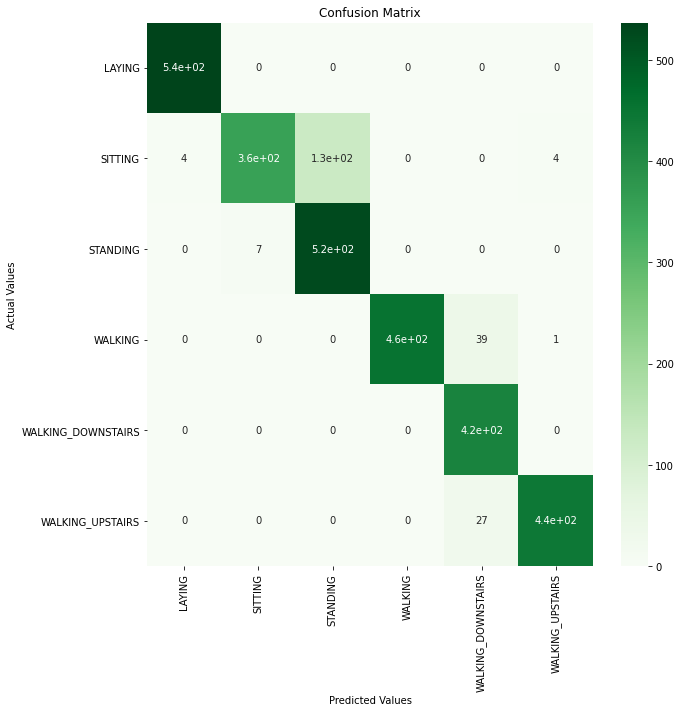

In [32]:
cm = confusion_matrix(Y_test, model_2.predict(X_test))
cm_df = pd.DataFrame(cm,
                     index = ['LAYING','SITTING','STANDING', 'WALKING', 'WALKING_DOWNSTAIRS','WALKING_UPSTAIRS'], 
                     columns = ['LAYING','SITTING','STANDING', 'WALKING', 'WALKING_DOWNSTAIRS','WALKING_UPSTAIRS'])
#Plotting the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True,cmap = plt.cm.Greens)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

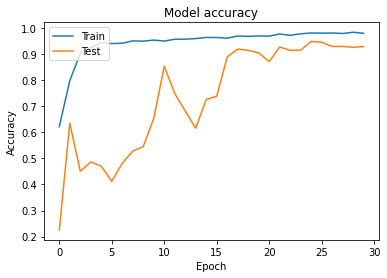

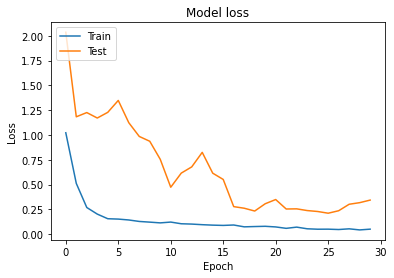

In [33]:
# Plot training & validation accuracy values
plt.plot(history_2.history['acc'])
plt.plot(history_2.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Plot training & validation loss values
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### 6 Conv Layers with Dropout,Batchnormalization, Maxpool

In [37]:
model_3 = Sequential()
model_3.add(Conv2D(64, kernel_size=(5, 5),activation='relu', padding='same', input_shape=input_shape))
model_3.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2), strides = 2))
model_3.add(Dropout(0.5))

model_3.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model_3.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2), strides = 2))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.5))


model_3.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model_3.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2), strides = 2))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.5))

model_3.add(Flatten())
model_3.add(Dense(100, activation='relu'))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.5))
model_3.add(Dense(n_classes, activation='softmax'))

model_3.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model_3.summary()
history_3 = model_3.fit(X_train, Y_train, batch_size=256, epochs=25, verbose=1, validation_data=(X_test, Y_test))
score_3 = model_3.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score_3[0])
print('Test accuracy:', score_3[1])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 128, 9, 64)        1664      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 128, 9, 64)        102464    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 4, 64)         0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 64, 4, 64)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 64, 4, 32)         18464     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 64, 4, 32)         9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 2, 32)        

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


7352/7352 [==============================] - 6s 778us/sample - loss: 1.4023 - acc: 0.4967 - val_loss: 1.8113 - val_acc: 0.1992
Epoch 2/25
7352/7352 [==============================] - 4s 486us/sample - loss: 0.8510 - acc: 0.6394 - val_loss: 1.8157 - val_acc: 0.3448
Epoch 3/25
7352/7352 [==============================] - 4s 488us/sample - loss: 0.6735 - acc: 0.7069 - val_loss: 2.6530 - val_acc: 0.2464
Epoch 4/25
7352/7352 [==============================] - 4s 486us/sample - loss: 0.5104 - acc: 0.7756 - val_loss: 4.0351 - val_acc: 0.2816
Epoch 5/25
7352/7352 [==============================] - 4s 486us/sample - loss: 0.3916 - acc: 0.8395 - val_loss: 4.4173 - val_acc: 0.2002
Epoch 6/25
7352/7352 [==============================] - 4s 487us/sample - loss: 0.2824 - acc: 0.8970 - val_loss: 5.1021 - val_acc: 0.1758
Epoch 7/25
7352/7352 [==============================] - 4s 487us/sample - loss: 0.2108 - acc: 0.9274 - val_loss: 5.1510 - val_acc: 0.1666
Epoch 8/25
7352/7352 [=======================

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


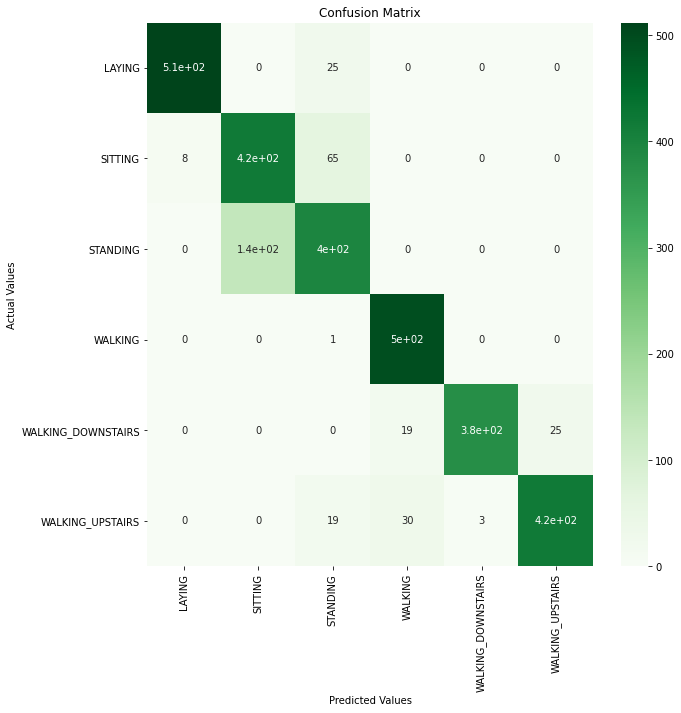

In [38]:
cm = confusion_matrix(Y_test, model_3.predict(X_test))
cm_df = pd.DataFrame(cm,
                     index = ['LAYING','SITTING','STANDING', 'WALKING', 'WALKING_DOWNSTAIRS','WALKING_UPSTAIRS'], 
                     columns = ['LAYING','SITTING','STANDING', 'WALKING', 'WALKING_DOWNSTAIRS','WALKING_UPSTAIRS'])
#Plotting the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True,cmap = plt.cm.Greens)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

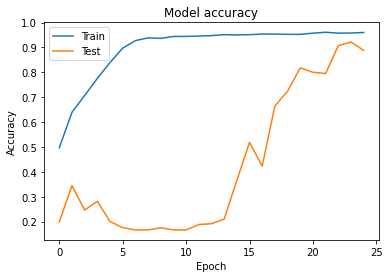

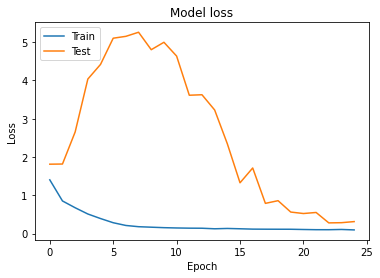

In [39]:
# Plot training & validation accuracy values
plt.plot(history_3.history['acc'])
plt.plot(history_3.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Plot training & validation loss values
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [21]:
from prettytable import PrettyTable 

x = PrettyTable()
x.field_names = ["Model no.", "Architecture",  "Test Loss(Cross-Entropy)", "Test Accuracy"]
x.add_row([1,"3 Conv Layers Without Dropout,BN(64,64 filters)", 0.27, 0.94 ])
x.add_row([2,"3 Conv Layers with dropout,BN(128,64,64 filters)", 0.224,0.906 ])
x.add_row([3, "4 Conv Layers with Dropout,BN, Maxpool(128,128,64,64)", 0.205,0.944])
x.add_row([4, "4 Conv Layers with Dropout,BN, Maxpool(64,64,32,32)", 0.34, 0.929])
x.add_row([5, "6 Conv Layers with Dropout,BN, Maxpool", 0.31 ,0.89])

print(x)

+-----------+-------------------------------------------------------+--------------------------+---------------+
| Model no. |                      Architecture                     | Test Loss(Cross-Entropy) | Test Accuracy |
+-----------+-------------------------------------------------------+--------------------------+---------------+
|     1     |    3 Conv Layers Without Dropout,BN(64,64 filters)    |           0.27           |      0.94     |
|     2     |    3 Conv Layers with dropout,BN(128,64,64 filters)   |          0.224           |     0.906     |
|     3     | 4 Conv Layers with Dropout,BN, Maxpool(128,128,64,64) |          0.205           |     0.944     |
|     4     |  4 Conv Layers with Dropout,BN, Maxpool(64,64,32,32)  |           0.34           |     0.929     |
|     5     |         6 Conv Layers with Dropout,BN, Maxpool        |           0.31           |      0.89     |
+-----------+-------------------------------------------------------+--------------------------+

### Conclusion :
1. We could achieve the scores above that of (expert eng. features + traditional ML algos.) Models.
2. Using Dropout , BN , Max Pool layers we could achieve better perfomance over train and test data.
3. We have highest accuracy and lowest loss for Model "4 Conv Layers with Dropout,BN, Maxpool ", 0.205, 0.944